# Knowledge Exploration

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
pd.set_option('display.max_rows', 200)

/home/kd-sem-ie/.local/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Load used entities

In [2]:
used_entities = pd.read_csv('used_entities.csv')
used_entities['method'] = used_entities['method'].str.strip()
print(len(used_entities[used_entities['probability'] > 0.5]))
print(len(used_entities[used_entities['probability'] <= 0.5]))
used_entities = used_entities.drop(['count', 'sentence'], axis=1)
used_entities

245803
192904


document_id                                        method  probability
0        2118681326                                         marcu     0.997502
1        2118681326                           machine translation     0.996561
2        2118681326                                      although     0.072608
3        2118681326                                       whereas     0.013132
4        2161668503                            maximum likelihood     0.977955
...             ...                                           ...          ...
438702   2511534620                   natural language processing     0.998385
438703   2511534620  neural autoregressive distribution estimator     0.998344
438704   2511534620                                   autoencoder     0.998020
438705   2511534620                      variational autoencoders     0.997877
438706   2511534620                                   variational     0.997877

[438707 rows x 3 columns]

### Preprocessing

#### 1.  Suffixes:
* bayesian inference algorithm => bayesian inference
* support vector machine classifier => support vector machine

In [3]:
# xxxx algorithm
used_entities['method'] = used_entities['method'].apply(
    lambda method: method[:method.rfind(" ")] if method.endswith(" algorithm")\
                                                or method.endswith(" algorithms")\
                                                or method.endswith(" classifier")\
                                                or method.endswith(" classifiers")\
                                              else method)
used_entities

document_id                                        method  probability
0        2118681326                                         marcu     0.997502
1        2118681326                           machine translation     0.996561
2        2118681326                                      although     0.072608
3        2118681326                                       whereas     0.013132
4        2161668503                            maximum likelihood     0.977955
...             ...                                           ...          ...
438702   2511534620                   natural language processing     0.998385
438703   2511534620  neural autoregressive distribution estimator     0.998344
438704   2511534620                                   autoencoder     0.998020
438705   2511534620                      variational autoencoders     0.997877
438706   2511534620                                   variational     0.997877

[438707 rows x 3 columns]

#### 2. Plural to singular:
* neural networks => neural network

In [4]:
# plural 2 singular: check if method ends with an "s" and if it does,
# check whether the df contains the method name without the "s".
# Warning: this might take a while...
method_series = used_entities['method'].unique()
print(len(method_series))
used_entities['method'] = used_entities['method'].apply(
    lambda method: method[:-2] if len(method) > 2 and method[-2] == "es" and method[:-2] in method_series\
                                else method[:-1] if method[-1] == "s" and method[:-1] in method_series\
                                else method)
used_entities

82752


document_id                                        method  probability
0        2118681326                                         marcu     0.997502
1        2118681326                           machine translation     0.996561
2        2118681326                                      although     0.072608
3        2118681326                                       whereas     0.013132
4        2161668503                            maximum likelihood     0.977955
...             ...                                           ...          ...
438702   2511534620                   natural language processing     0.998385
438703   2511534620  neural autoregressive distribution estimator     0.998344
438704   2511534620                                   autoencoder     0.998020
438705   2511534620                       variational autoencoder     0.997877
438706   2511534620                                   variational     0.997877

[438707 rows x 3 columns]

#### 3. Wikidata alias lookup:
* neural network => artificial neural network
* nn => artificial neural network
* svm => support vector machine
* lstm => long short-term memory

In [5]:
# read csv file
# each entry consists of the "default"-entity name and an alias for it
method_aliases = pd.read_csv('method_aliases.csv', sep=';')
method_aliases['aliases'] = method_aliases['aliases'].str.lower()
method_aliases['method'] = method_aliases['method'].str.lower()
# join our entities with the aliases and then reduce to the method column in the csv
df_alias = used_entities.merge(method_aliases, 'left', left_on='method', right_on='aliases')
df_alias['method'] = df_alias['method_y'].combine_first(df_alias['method_x'])
df_alias = df_alias.drop(['method_x', 'method_y', 'aliases'], axis=1)
df_alias

document_id  probability                                        method
0        2118681326     0.997502                                         marcu
1        2118681326     0.996561                           machine translation
2        2118681326     0.072608                                      although
3        2118681326     0.013132                                       whereas
4        2161668503     0.977955                            maximum likelihood
...             ...          ...                                           ...
438702   2511534620     0.998385                   natural language processing
438703   2511534620     0.998344  neural autoregressive distribution estimator
438704   2511534620     0.998020                                   autoencoder
438705   2511534620     0.997877                       variational autoencoder
438706   2511534620     0.997877                                   variational

[438707 rows x 3 columns]

#### 4. Custom mappings:
* deep neural network dnn => deep neural network
* standard convolutional => convolutional neural network

In [6]:
df_alias['method'] = df_alias['method'].replace('artificial neural network ann', 'artificial neural network')
df_alias['method'] = df_alias['method'].replace('artificial neural networks ann', 'artificial neural network')
df_alias['method'] = df_alias['method'].replace('artificial neural networks anns', 'artificial neural network')
df_alias['method'] = df_alias['method'].replace('neural network nn', 'artificial neural network')
df_alias['method'] = df_alias['method'].replace('neural networks nn', 'artificial neural network')
df_alias['method'] = df_alias['method'].replace('deep neural network dnn', 'deep neural network')
df_alias['method'] = df_alias['method'].replace('deep neural networks dnn', 'deep neural network')
df_alias['method'] = df_alias['method'].replace('standard convolutional', 'convolutional neural network')
df_alias['method'] = df_alias['method'].replace('convolutional', 'convolutional neural network')
df_alias['method'] = df_alias['method'].replace('convolutional neural', 'convolutional neural network')
df_alias['method'] = df_alias['method'].replace('multiple convolutional', 'convolutional neural network')
df_alias['method'] = df_alias['method'].replace('deep convolutional', 'deep convolutional neural network')
df_alias['method'] = df_alias['method'].replace('convolutional autoencoder', 'convolutional autoencoder neural network')
df_alias['method'] = df_alias['method'].replace('genetic algorithm ga', 'genetic algorithm')
df_alias['method'] = df_alias['method'].replace('stanford natural language learning', 'natural language')
df_alias['method'] = df_alias['method'].replace('stanford natural language inference', 'natural language')
df_alias['method'] = df_alias['method'].replace('natural language inference', 'natural language')
df_alias['method'] = df_alias['method'].replace('natural language learning', 'natural language')
df_alias['method'] = df_alias['method'].replace('natural language', 'natural language processing')
df_alias['method'] = df_alias['method'].replace('random forest rf', 'random forest')
df_alias['method'] = df_alias['method'].replace('random forests rf', 'random forest')
df_alias['method'] = df_alias['method'].replace('support vector machines svms', 'support vector machine')
df_alias['method'] = df_alias['method'].replace('svms', 'support vector machine')
df_alias['method'] = df_alias['method'].replace('linear support vector machine', 'support vector machine')
df_alias['method'] = df_alias['method'].replace('least square support vector machine', 'support vector machine')
df_alias['method'] = df_alias['method'].replace('least squares support vector machine', 'support vector machine')
df_alias['method'] = df_alias['method'].replace('multiclass support vector machine', 'support vector machine')
df_alias['method'] = df_alias['method'].replace('transductive support vector machine', 'support vector machine')
df_alias['method'] = df_alias['method'].replace('decision tree dt', 'decision tree')
df_alias['method'] = df_alias['method'].replace('decision tree learning', 'decision tree')
df_alias['method'] = df_alias['method'].replace('logistic regression lr', 'logistic regression')
df_alias['method'] = df_alias['method'].replace('naive bayes nb', 'naive bayes')
df_alias['method'] = df_alias['method'].replace('naive bayesian', 'naive bayes')
df_alias['method'] = df_alias['method'].replace('naive bayes classifier', 'naive bayes')
df_alias['method'] = df_alias['method'].replace('naive baye', 'naive bayes')

#### 5. Custom filtering

In [7]:
filtered_df = df_alias.drop(
    df_alias[
           (df_alias['method'] == 'dataset')
         | (df_alias['method'] == 'although')
         | (df_alias['method'] == 'whereas')
         | (df_alias['method'] == 'the accuracy')
         | (df_alias['method'] == 'accuracy of')
         | (df_alias['method'] == 'characteristics of')
         | (df_alias['method'] == 'the accuracy of')
         | (df_alias['method'] == 'the accuracy of the')
         | (df_alias['method'] == 'input and')
         | (df_alias['method'] == 'keyword')
         | (df_alias['method'] == 'multi')
         | (df_alias['method'] == 'algorithm')
    ].index)
filtered_df

document_id  probability                                        method
0        2118681326     0.997502                                         marcu
1        2118681326     0.996561                           machine translation
4        2161668503     0.977955                            maximum likelihood
5        2161668503     0.696023                              machine learning
6        2161668503     0.550583                            bayesian inference
...             ...          ...                                           ...
438702   2511534620     0.998385                   natural language processing
438703   2511534620     0.998344  neural autoregressive distribution estimator
438704   2511534620     0.998020                                   autoencoder
438705   2511534620     0.997877                       variational autoencoder
438706   2511534620     0.997877                                   variational

[390386 rows x 3 columns]

#### 6. Drop duplicates

In [8]:
unique_df = filtered_df.drop_duplicates()
unique_df

document_id  probability                                        method
0        2118681326     0.997502                                         marcu
1        2118681326     0.996561                           machine translation
4        2161668503     0.977955                            maximum likelihood
5        2161668503     0.696023                              machine learning
6        2161668503     0.550583                            bayesian inference
...             ...          ...                                           ...
438702   2511534620     0.998385                   natural language processing
438703   2511534620     0.998344  neural autoregressive distribution estimator
438704   2511534620     0.998020                                   autoencoder
438705   2511534620     0.997877                       variational autoencoder
438706   2511534620     0.997877                                   variational

[390120 rows x 3 columns]

### Word Cloud

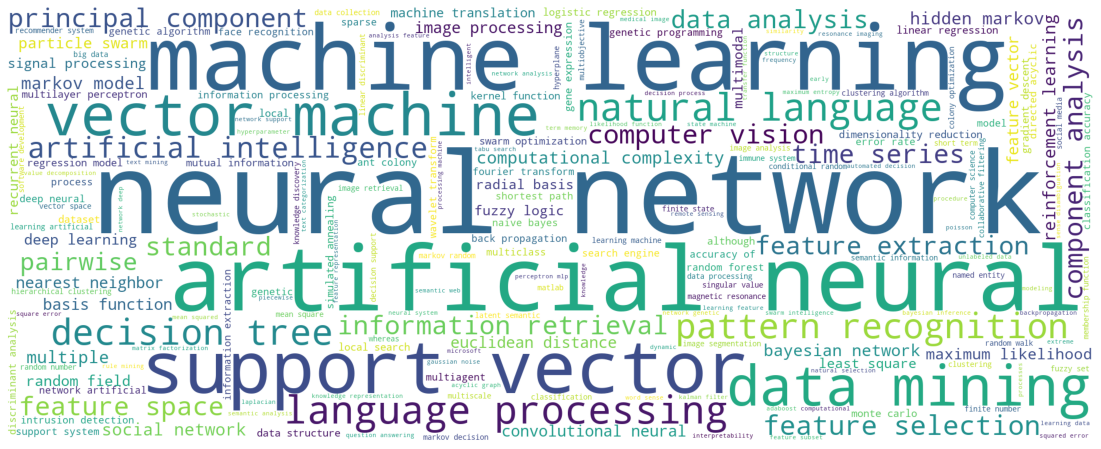

In [9]:
wc = WordCloud(background_color="white", width=2000, height=800)
wc.generate(' '.join(unique_df['method'].values))
plt.figure(figsize=(20, 8))
plt.axis('off')
plt.imshow(wc)
plt.show()

## Load MAG paper metadata

In [10]:
papers = pd.read_csv('papers.csv')
papers

document_id                                              title  \
0           385572  A Generic Framework Based on Machine Learning ...   
1           728297  An Optimized Cost-Sensitive SVM for Imbalanced...   
2           954605  Exploiting Trust and Suspicion for Real-time A...   
3          1543681  An Adequate Representation of Medical Data Bas...   
4          1632977  A Bayesian Strategy to Enhance the Performance...   
...            ...                                                ...   
25039   2889995140  Intelligent Model Conception Proposal for Adap...   
25040   2890772535  Multi-level temporal autoregressive modelling ...   
25041   2891610319  Artificial Neural Network based Weather Predic...   
25042   2893045341  pysster: classification of biological sequence...   
25043   2897013524             AN OVERVIEW OF FACE LIVENESS DETECTION   

       published_year  citation_count  \
0                2005               1   
1                2013              50   
2                2007               3   
3                2013               1   
4                2011               2   
...               ...             ...   
25039            2018               0   
25040            2018               0   
25041            2018               0   
25042            2018               5   
25043            2014              16   

                                          original_venue  \
0              working conference on virtual enterprises   
1      pacific-asia conference on knowledge discovery...   
2           international conference on trust management   
3      computer information systems and industrial ma...   
4                                                    NaN   
...                                                  ...   
25039  International Journal of Advanced Computer Sci...   
25040  International Journal of Geographical Informat...   
25041  International Journal of Advanced Computer Sci...   
25042                                     Bioinformatics   
25043     arXiv: Computer Vision and Pattern Recognition   

                                            journal_name  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
25039  International Journal of Advanced Computer Sci...   
25040  International Journal of Geographical Informat...   
25041  International Journal of Advanced Computer Sci...   
25042                                     Bioinformatics   
25043     arXiv: Computer Vision and Pattern Recognition   

       journal_citation_count  journal_paper_count  \
0                         NaN                  NaN   
1                         NaN                  NaN   
2                         NaN                  NaN   
3                         NaN                  NaN   
4                         NaN                  NaN   
...                       ...                  ...   
25039                  8438.0               4534.0   
25040                 57466.0               2314.0   
25041                  8438.0               4534.0   
25042                973342.0              13665.0   
25043                 30059.0               9993.0   

                                         conference_name  \
0              Working Conference on Virtual Enterprises   
1      Pacific-Asia Conference on Knowledge Discovery...   
2           International Conference on Trust Management   
3      Computer Information Systems and Industrial Ma...   
4                                                    NaN   
...                                                  ...   
25039                                                NaN   
25040                                                NaN   
25041 

### Join document-ids from used entities onto MAG document-ids

In [11]:
paper_years = papers[['document_id', 'published_year']]
entities_years = unique_df.merge(paper_years, on='document_id')
entities_years = entities_years[(2004 < entities_years['published_year']) & (entities_years['published_year'] < 2019)]
entities_years['count'] = 1
entities_years

document_id  probability  \
0        2118681326     0.997502   
1        2118681326     0.996561   
2        2161668503     0.977955   
3        2161668503     0.696023   
4        2161668503     0.550583   
...             ...          ...   
389934   2511534620     0.998385   
389935   2511534620     0.998344   
389936   2511534620     0.998020   
389937   2511534620     0.997877   
389938   2511534620     0.997877   

                                              method  published_year  count  
0                                              marcu            2005      1  
1                                machine translation            2005      1  
2                                 maximum likelihood            2005      1  
3                                   machine learning            2005      1  
4                                 bayesian inference            2005      1  
...                                              ...             ...    ...  
389934                   natural language processing            2018      1  
389935  neural autoregressive distribution estimator            2018      1  
389936                                   autoencoder            2018      1  
389937                       variational autoencoder            2018      1  
389938                                   variational            2018      1  

[389660 rows x 5 columns]

### Calculate relative usage

In [49]:
df = entities_years
df['probability'] = df['probability'].round()
df = df.drop(['document_id'], axis=1).groupby(['method', 'published_year']).agg({'count': 'sum', 'probability': 'mean'}).reset_index().sort_values('published_year')
df

method  published_year  count  probability
0       0 accuracy of the standard            2005      1          0.0
101559           random projection            2005      1          0.0
6954              automatic speech            2005      1          1.0
82617           naive segmentation            2005      1          1.0
34562         exponential function            2005      1          1.0
...                            ...             ...    ...          ...
38389               feature subset            2018     12          0.5
97687                     pseudot2            2018      1          0.0
9415               bayesian sparse            2018      1          0.0
127360  time series social network            2018      1          0.0
108634            screened poisson            2018      1          0.0

[136476 rows x 4 columns]

In [68]:
entities = ["artificial neural network", "convolutional neural network",
            "support vector machine", "conditional random field"]
#entities = ["genetic"]
            #"random forest", "decision tree"]#,
#            "natural language processing", "reinforcement learning"]
#entities = ["support vector machine", "random forest"]
data = df[df['method'].isin(entities)]
data = data[data['count'] >= 15]
#data.drop('published_year', axis=1).groupby('method').agg({'count': 'sum', 'probability': 'mean'})
data

method  published_year  count  probability
5870       artificial neural network            2005    520     0.640385
123407        support vector machine            2005    345     0.602899
19428       conditional random field            2005     46     0.695652
123408        support vector machine            2006    402     0.574627
19429       conditional random field            2006     41     0.487805
5871       artificial neural network            2006    546     0.692308
19430       conditional random field            2007     24     0.666667
5872       artificial neural network            2007    671     0.701937
123409        support vector machine            2007    372     0.602151
5873       artificial neural network            2008    617     0.669368
123410        support vector machine            2008    403     0.607940
19431       conditional random field            2008     49     0.673469
123411        support vector machine            2009    314     0.621019
5874       artificial neural network            2009    468     0.737179
19432       conditional random field            2009     59     0.627119
5875       artificial neural network            2010    665     0.703759
123412        support vector machine            2010    372     0.629032
19433       conditional random field            2010     24     0.791667
19434       conditional random field            2011     34     0.558824
5876       artificial neural network            2011    769     0.716515
123413        support vector machine            2011    350     0.640000
123414        support vector machine            2012    381     0.635171
20342   convolutional neural network            2012     21     0.333333
5877       artificial neural network            2012    834     0.676259
19435       conditional random field            2012     40     0.775000
123415        support vector machine            2013    341     0.662757
20343   convolutional neural network            2013     21     0.428571
19436       conditional random field            2013     16     0.750000
5878       artificial neural network            2013    834     0.701439
123416        support vector machine            2014    385     0.657143
19437       conditional random field            2014     39     0.615385
20344   convolutional neural network            2014     68     0.544118
5879       artificial neural network            2014    702     0.698006
20345   convolutional neural network            2015     91     0.527473
5880       artificial neural network            2015    809     0.681088
19438       conditional random field            2015     21     0.666667
123417        support vector machine            2015    356     0.620787
20346   convolutional neural network            2016    303     0.488449
123418        support vector machine            2016    430     0.644186
19439       conditional random field            2016     44     0.750000
5881       artificial neural network            2016    880     0.681818
123419        support vector machine            2017    363     0.606061
5882       artificial neural network            2017    974     0.668378
19440       conditional random field            2017     41     0.707317
20347   convolutional neural network            2017    635     0.530709
5883       artificial neural network            2018   1011     0.638971
123420        support vector machine            2018    289     0.626298
19441       conditional random field            2018     41     0.804878
20348   convolutional neural network            2018    586     0.568259

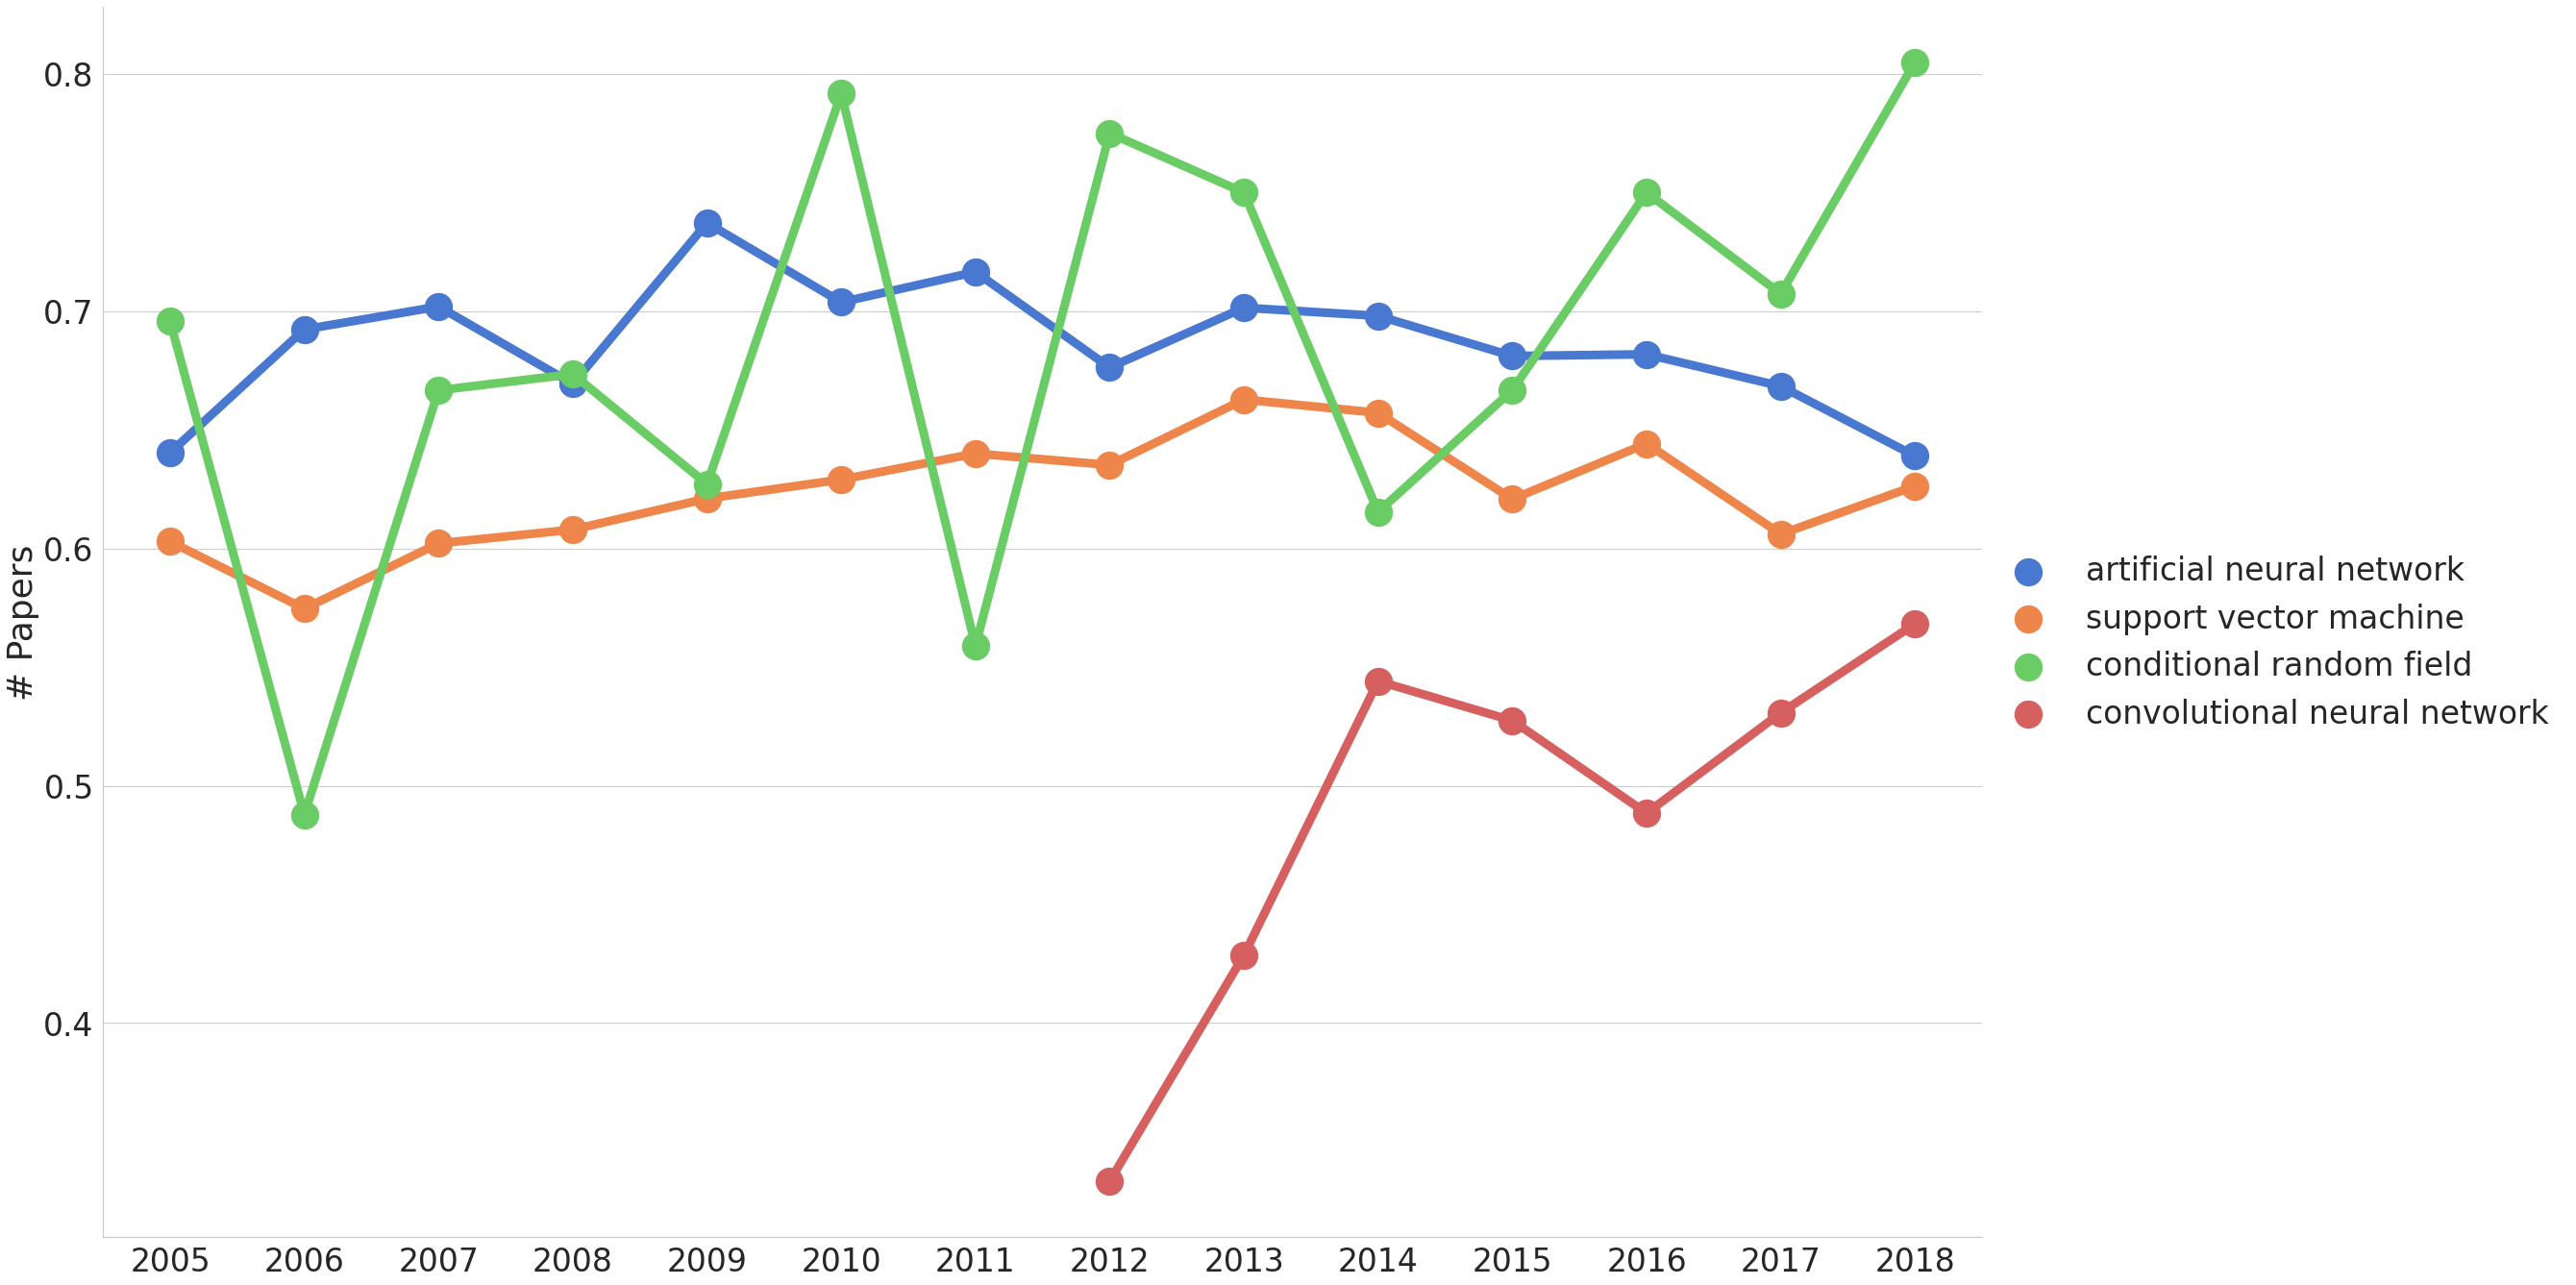

In [69]:
sns.set(style="whitegrid", font_scale=3, rc={"lines.linewidth": 5})
g = sns.catplot(x="published_year", y="probability", hue="method", data=data,
                kind="point", height=20, aspect=1.5, palette=sns.color_palette("muted"))
g.set_axis_labels("", "# Papers")
g._legend.set_title("")

### Group by method and published year

In [16]:
df = entities_years[entities_years['probability'] > 0.5]
df = df.drop(['document_id', 'probability'], axis=1).groupby(['method', 'published_year']).sum().reset_index().sort_values('published_year')
df = df[df['count'] >= 5]
df

method  published_year  count
60979                  short term            2005      5
17027            english language            2005      5
61425           signal processing            2005      8
61111               shortest path            2005     16
17660                  error term            2005      9
...                           ...             ...    ...
45908             neural language            2018      7
9523   computational intelligence            2018      6
36448        mahalanobis distance            2018      6
36430                 mahalanobis            2018      5
36407  magnetic resonance imaging            2018      7

[4750 rows x 3 columns]

---
## 1. Find top used methods

In [17]:
top_methods = df.drop('published_year', axis=1).groupby('method').sum()
top_methods = top_methods.sort_values('count', ascending=False)
top_methods[:200]

count
method                                  
artificial neural network           3254
support vector machine              1922
machine learning                    1889
matlab                              1597
feature vector                      1393
decision tree                       1360
cross validation                    1310
pairwise                            1282
classification accuracy             1221
error rate                          1146
euclidean distance                  1079
nearest neighbor                    1056
feature extraction                  1047
feature selection                   1024
genetic                              882
convolutional neural network         819
computational complexity             789
time series                          769
random number                        749
hyperparameter                       747
feature space                        723
multiclass                           597
random forest                        560
gradient descent                     539
maximum likelihood                   523
naive bayes                          522
roc curve                            509
logistic regression                  506
data collection                      492
softmax                              478
backpropagation                      476
mutual information                   475
least square                         474
mean square error                    442
data analysis                        440
gaussian noise                       431
monte carlo                          428
linear regression                    425
intel                                422
principal component                  419
data mining                          418
kernel function                      403
natural language processing          400
data structure                       399
stochastic gradient descent          394
bayesian network                     385
radial basis function                380
local search                         374
false positive rate                  370
shortest path                        367
principal component analysis         366
regression model                     363
cosine similarity                    347
mean squared error                   344
perceptron                           342
multimodal                           337
deep neural network                  324
back propagation                     320
gaussian kernel                      319
membership function                  315
hyperplane                           312
support vector                       304
random selection                     300
microsoft                            300
hidden markov model                  299
clustering algorithm                 298
dimensionality reduction             295
random sampling                      295
pearson correlation                  291
optimizer                            290
reinforcement learning               287
multilayer perceptron                284
artificial intelligence              284
adaboost                             279
social network                       277
long short-term memory               269
viterbi                              269
poisson                              264
transfer function                    264
random walk                          257
multilayer                           253
mean absolute error                  250
multiobjective                       248
recurrent neural network             247
pattern recognition                  245
data processing                      241
hierarchical clustering              240
deep learning                        239
root mean square error               238
feature representation               225
classification accuracy of           218
lagrange multiplier                  216
singular value decomposition         215
simulated annealing                  212
information retrieval                211
false alarm                          210
gene expression  

### Select subset of entities

In [35]:
entities = ["artificial neural network", "convolutional neural network", "deep neural network",
            "long short-term memory", "support vector machine", "conditional random field"]
#entities = ["genetic"]
            #"random forest", "decision tree"]#,
#            "natural language processing", "reinforcement learning"]
#entities = ["support vector machine", "random forest"]
data = df[df['method'].str.contains('|'.join(entities), regex=True)]
df[df['method'].str.contains('|'.join(entities), regex=True)].drop('published_year', axis=1).groupby('method').sum().sort_values('count', ascending=False)

probability
method                                                         
artificial neural network                              9.607410
artificial neural network analysis                     1.000000
artificial neural network anns                         1.500000
artificial neural network artificial neural net...     1.000000
artificial neural network backpropagation              1.500000
artificial neural network checks accuracy of           0.000000
artificial neural network clustering                   0.000000
artificial neural network committee machines           2.000000
artificial neural network constructive cost model      0.000000
artificial neural network development                  1.000000
artificial neural network elman neural network         1.000000
artificial neural network error backpropagation        1.000000
artificial neural network ffann                        0.000000
artificial neural network fitting                      0.000000
artificial neural network function                     0.000000
artificial neural network fuzzy                        1.000000
artificial neural network fuzzy interface syste...     1.000000
artificial neural network gann                         1.000000
artificial neural network image                        0.000000
artificial neural network intrusion detection          1.000000
artificial neural network learning                     3.500000
artificial neural network liu zhongpei                 1.000000
artificial neural network metaheuristics               0.000000
artificial neural network model                        1.000000
artificial neural network modeling                     1.000000
artificial neural network multilayer                   1.000000
artificial neural network multilayer perceptron        1.000000
artificial neural network multilayer perceptron...     1.000000
artificial neural network network                      1.000000
artificial neural network neural networks              1.000000
artificial neural network nn                           5.000000
artificial neural network properties                   1.000000
artificial neural network prosperities                 1.000000
artificial neural network recurrent                    1.000000
artificial neural network structure                    0.000000
artificial neural network system                       2.000000
artificial neural network unsupervised                 1.000000
artificial neural networkann                           2.000000
artificial neural networks although                    2.000000
artificial neural networks annsbased                   1.000000
artificial neural networks artificial neural ne...     1.000000
artificial neural networks back propagation            1.000000
artificial neural networks eanns                       1.000000
artificial neural networks for network intrusion       1.000000
artificial neural networks for pattern recognition     1.000000
artificial neural networks machine learning            1.000000
artificial neural networks neural networks             2.000000
artificial neural networks nn                          4.000000
artificial neural networks optimal                     1.000000
artificial neural networks toolbox                     0.000000
artificial neural networks which                       0.000000
artificial neural networksand                          0.000000
artificial neural networksann                          1.000000
artificial neural networksapplication                  1.000000
conditional random field                               9.570448
conditional random field crfperf                       0.000000
conditional random field extraction                    0.000000
conditional random field model                         0.000000
conditional random field whereas recall                0.000000
conditional random fieldbased semantic                 0.000000
conditional random fields although                     3.000000
conditional random f

### Plot number of documents which used a specific entity over time

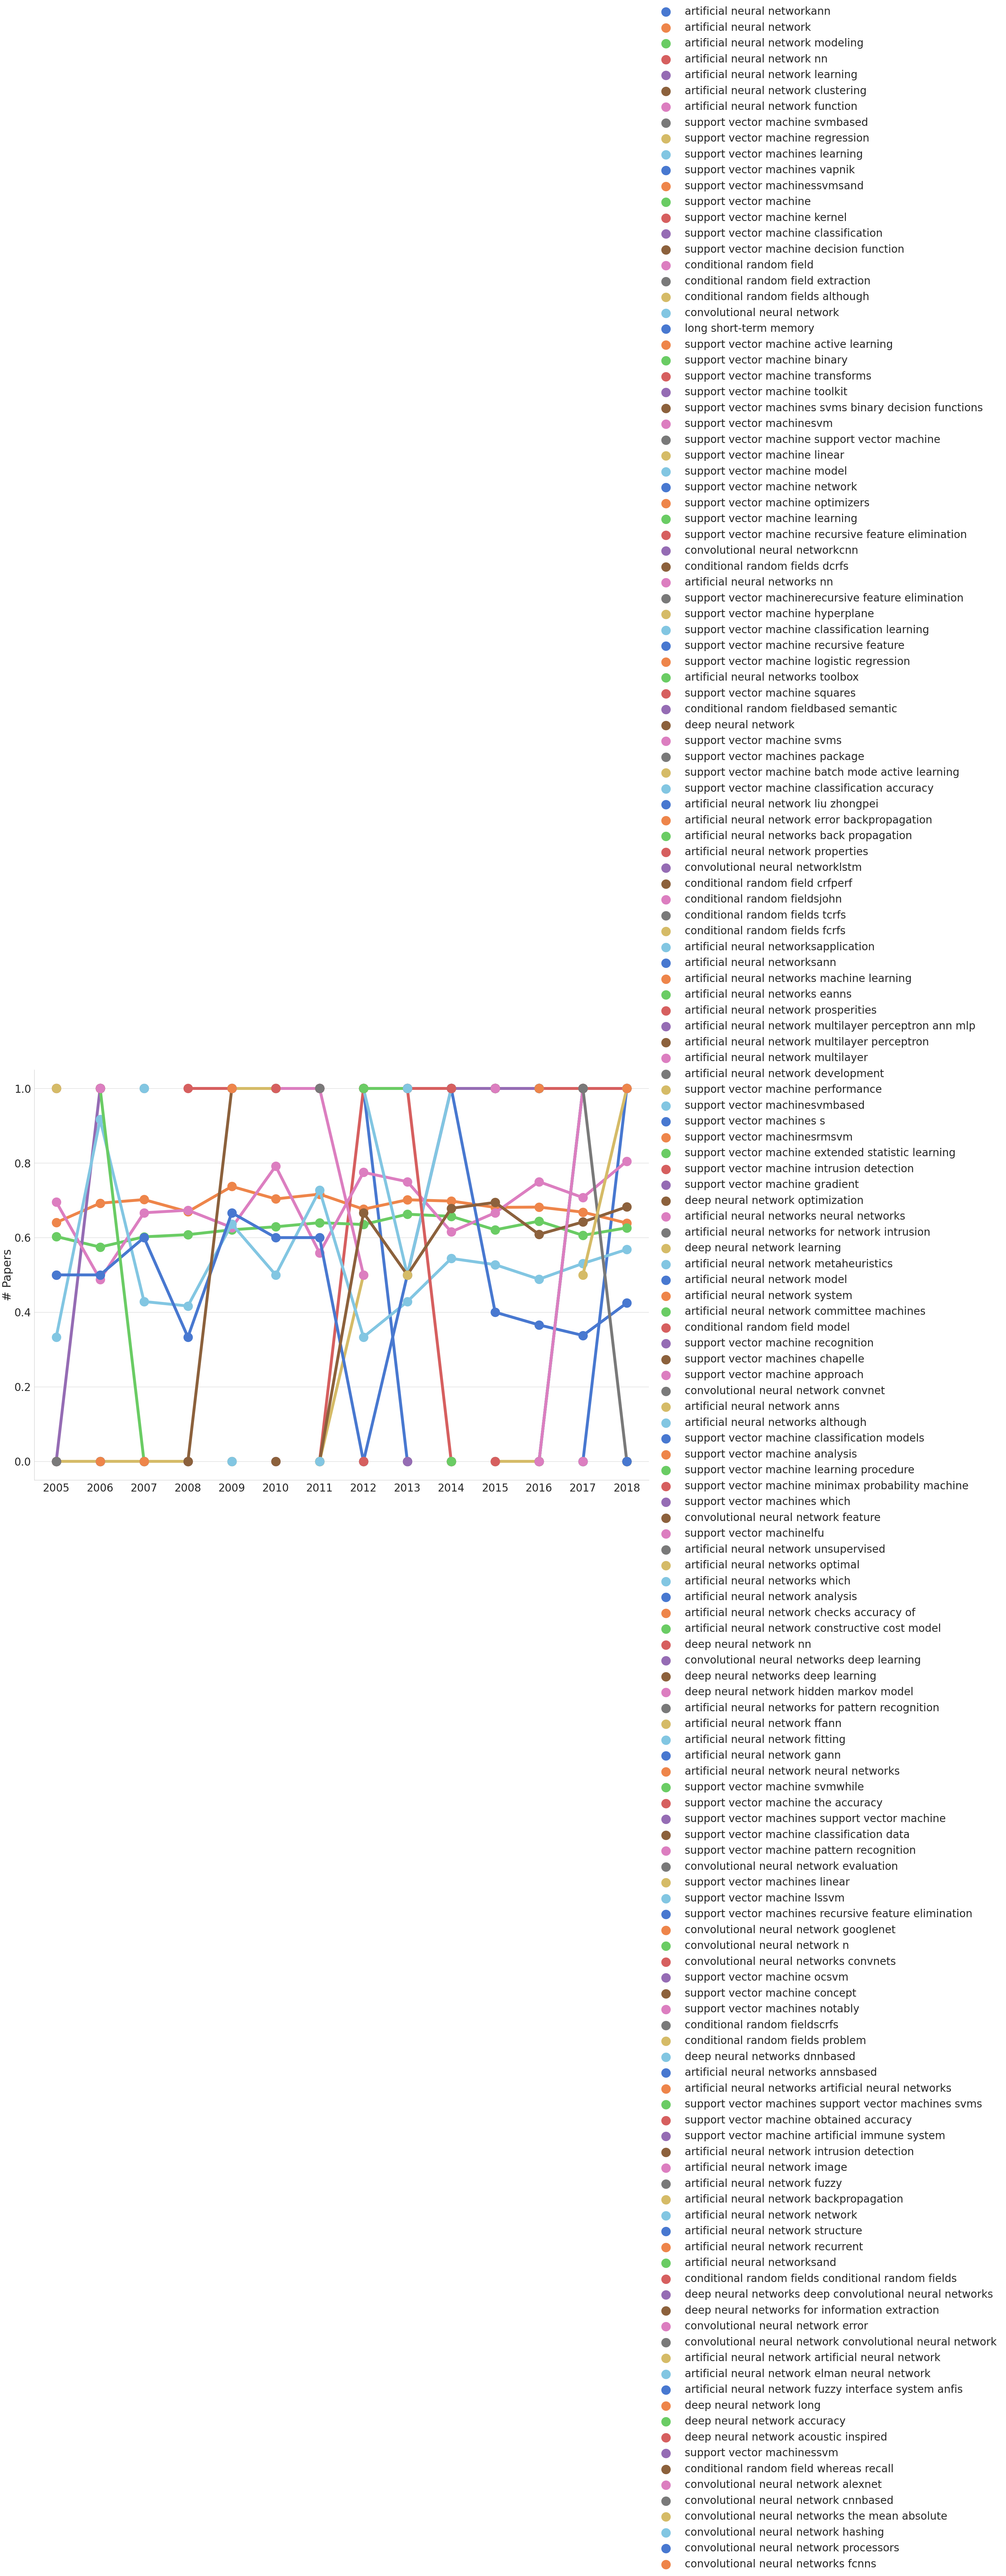

In [36]:
sns.set(style="whitegrid", font_scale=3, rc={"lines.linewidth": 5})
g = sns.catplot(x="published_year", y="count", hue="method", data=data,
                kind="point", height=20, aspect=1.5, palette=sns.color_palette("muted"))
g.set_axis_labels("", "# Papers")
g._legend.set_title("")

---
## 2. Field of study

In [16]:
fos = pd.read_csv('fieldsofstudy.csv')
fos

document_id                   field_of_study
0            385572            Collaborative network
1            385572             Knowledge management
2            385572                 Computer science
3            385572          Artificial intelligence
4            728297          Artificial intelligence
...             ...                              ...
242831   2890082230                    Binary number
242832   2890197863                 Wireless network
242833   2890442302  Intelligibility (communication)
242834   2891338039                 Cluster analysis
242835   2897013524        Facial recognition system

[242836 rows x 2 columns]

In [17]:
fos['count'] = 1
fos.groupby('field_of_study').count().reset_index().sort_values('count', ascending=False)[:200]

field_of_study  document_id  count
2436                        Computer science        24993  24993
663                  Artificial intelligence        24423  24423
7378                        Machine learning        23855  23855
9336                     Pattern recognition         5684   5684
3153                             Data mining         4289   4289
667                Artificial neural network         2659   2659
8407             Natural language processing         1729   1729
2443                         Computer vision         1725   1725
7556               Mathematical optimization         1527   1527
2011                        Cluster analysis         1428   1428
12588                 Support vector machine         1397   1397
12988           Theoretical computer science         1315   1315
355                                Algorithm         1198   1198
5282                       Genetic algorithm          978    978
5118                             Fuzzy logic          865    865
1156                          Bioinformatics          820    820
9955                     Probabilistic logic          772    772
11638                             Simulation          740    740
6221                               Inference          708    708
4682                       Feature selection          697    697
621                             Architecture          688    688
11876                               Software          582    582
4674                      Feature extraction          582    582
1934                Classifier (linguistics)          579    579
5460                                   Graph          578    578
4424                  Evolutionary algorithm          577    577
10991          Robustness (computer science)          540    540
3171                                Data set          526    526
13219                           Training set          526    526
10733                 Reinforcement learning          521    521
3714                   Distributed computing          515    515
12113                     Speech recognition          514    514
2360                             Computation          508    508
9710                              Population          500    500
2075                               Cognition          493    493
4684                          Feature vector          448    448
5736                               Heuristic          445    445
11149                            Scalability          444    444
3284                           Deep learning          444    444
10538                                Ranking          437    437
10967                                  Robot          422    422
13577                  Unsupervised learning          416    416
6284                   Information retrieval          415    415
12576                    Supervised learning          398    398
3256                           Decision tree          393    393
2739            Convolutional neural network          374    374
5746                     Hidden Markov model          373    373
3655                    Discriminative model          370    370
8983         Operator (computer programming)          358    358
9260                                 Parsing          353    353
11819                         Social network          349    349
4504                                 Exploit          349    349
995                         Bayesian network          348    348
9022                    Optimization problem          345    345
11373               Semi-supervised learning          335    335
9282             Particle swarm optimization          326    326
2709                          Control theory          326    326
4428                Evolutionary computation          313    313
12697                                 Syntax          310    310
12956                            Text mining          309    309
8601                            Neuroscience          307    307


#### Interesting topics:
* Pattern recognition
* Data mining
* (artificial neural network)
* Natural language processing
* Computer vision
* Cluster analysis
* Reinforcement learning
* Speech recognition

#### Steps:
1. Count FoS papers over years
2. Find most used entities of selected papers
3. Plot most used entities over years

### 1. Pattern recognition

<ipython-input-18-eb2dd4b6ff7a>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year_total'] = data.loc[:,'published_year'].apply(lambda year: data[data['published_year'] == year]['count'].sum())
<ipython-input-18-eb2dd4b6ff7a>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['count_rel'] = data['count'] / data['year_total'] * 100
<ipython-input-18-eb2dd4b6ff7a>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

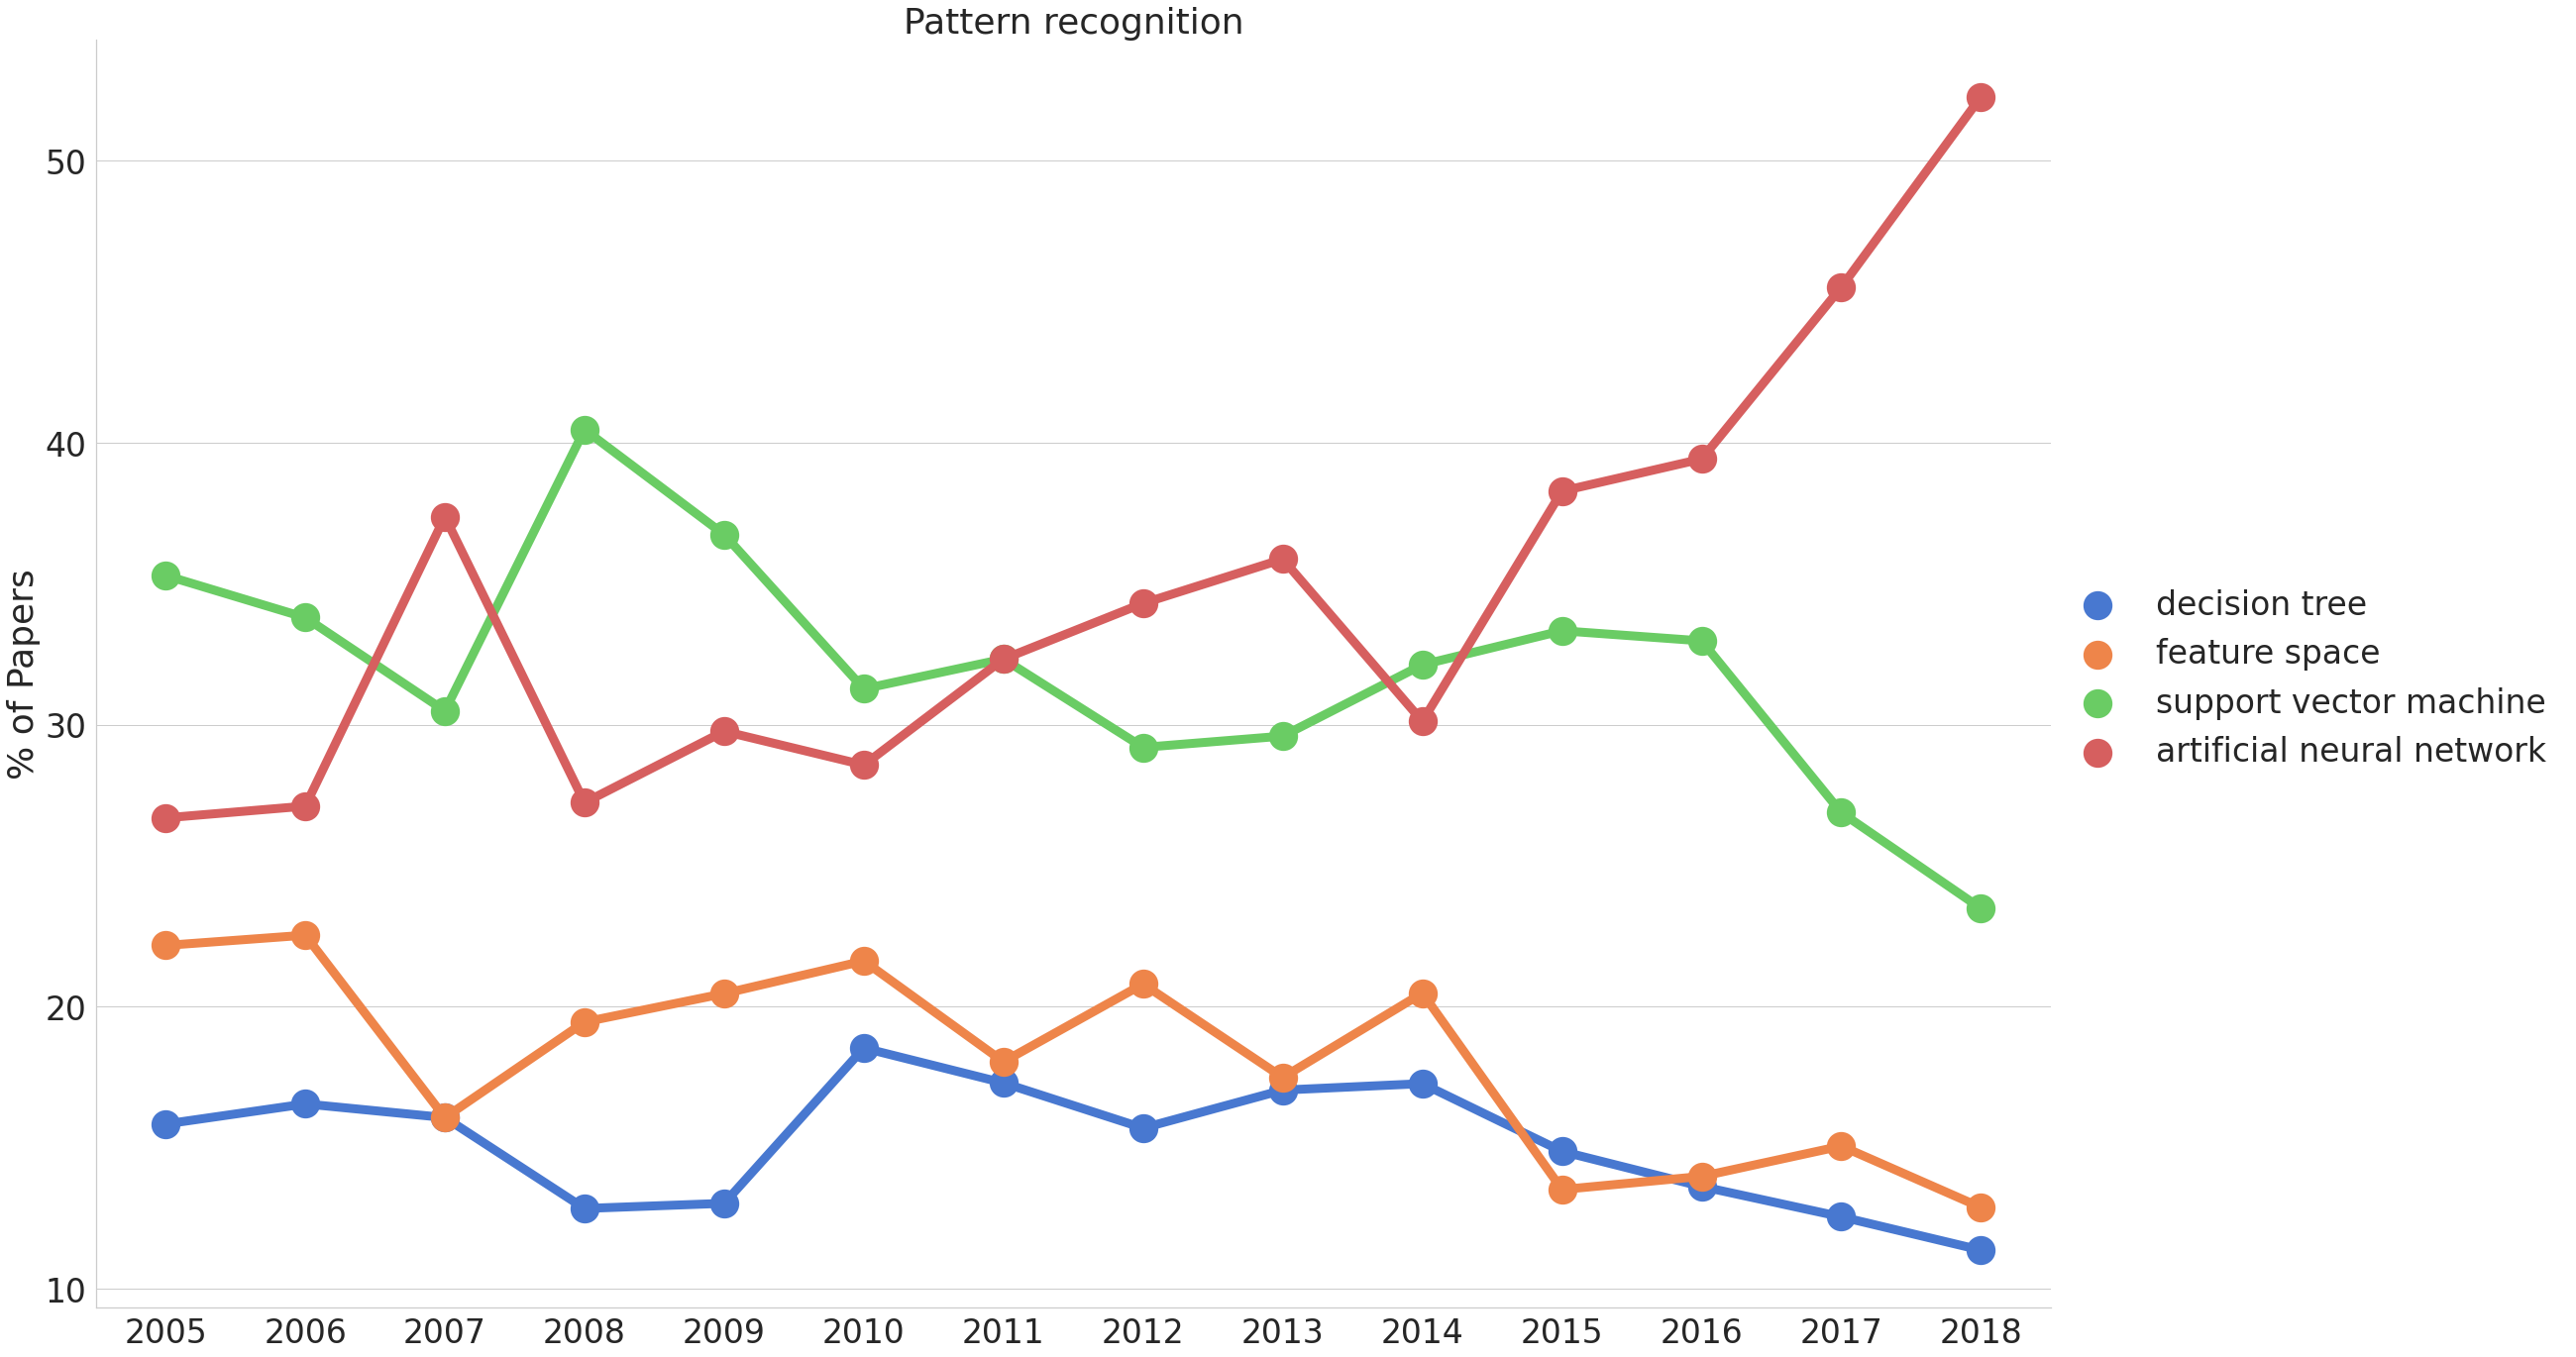

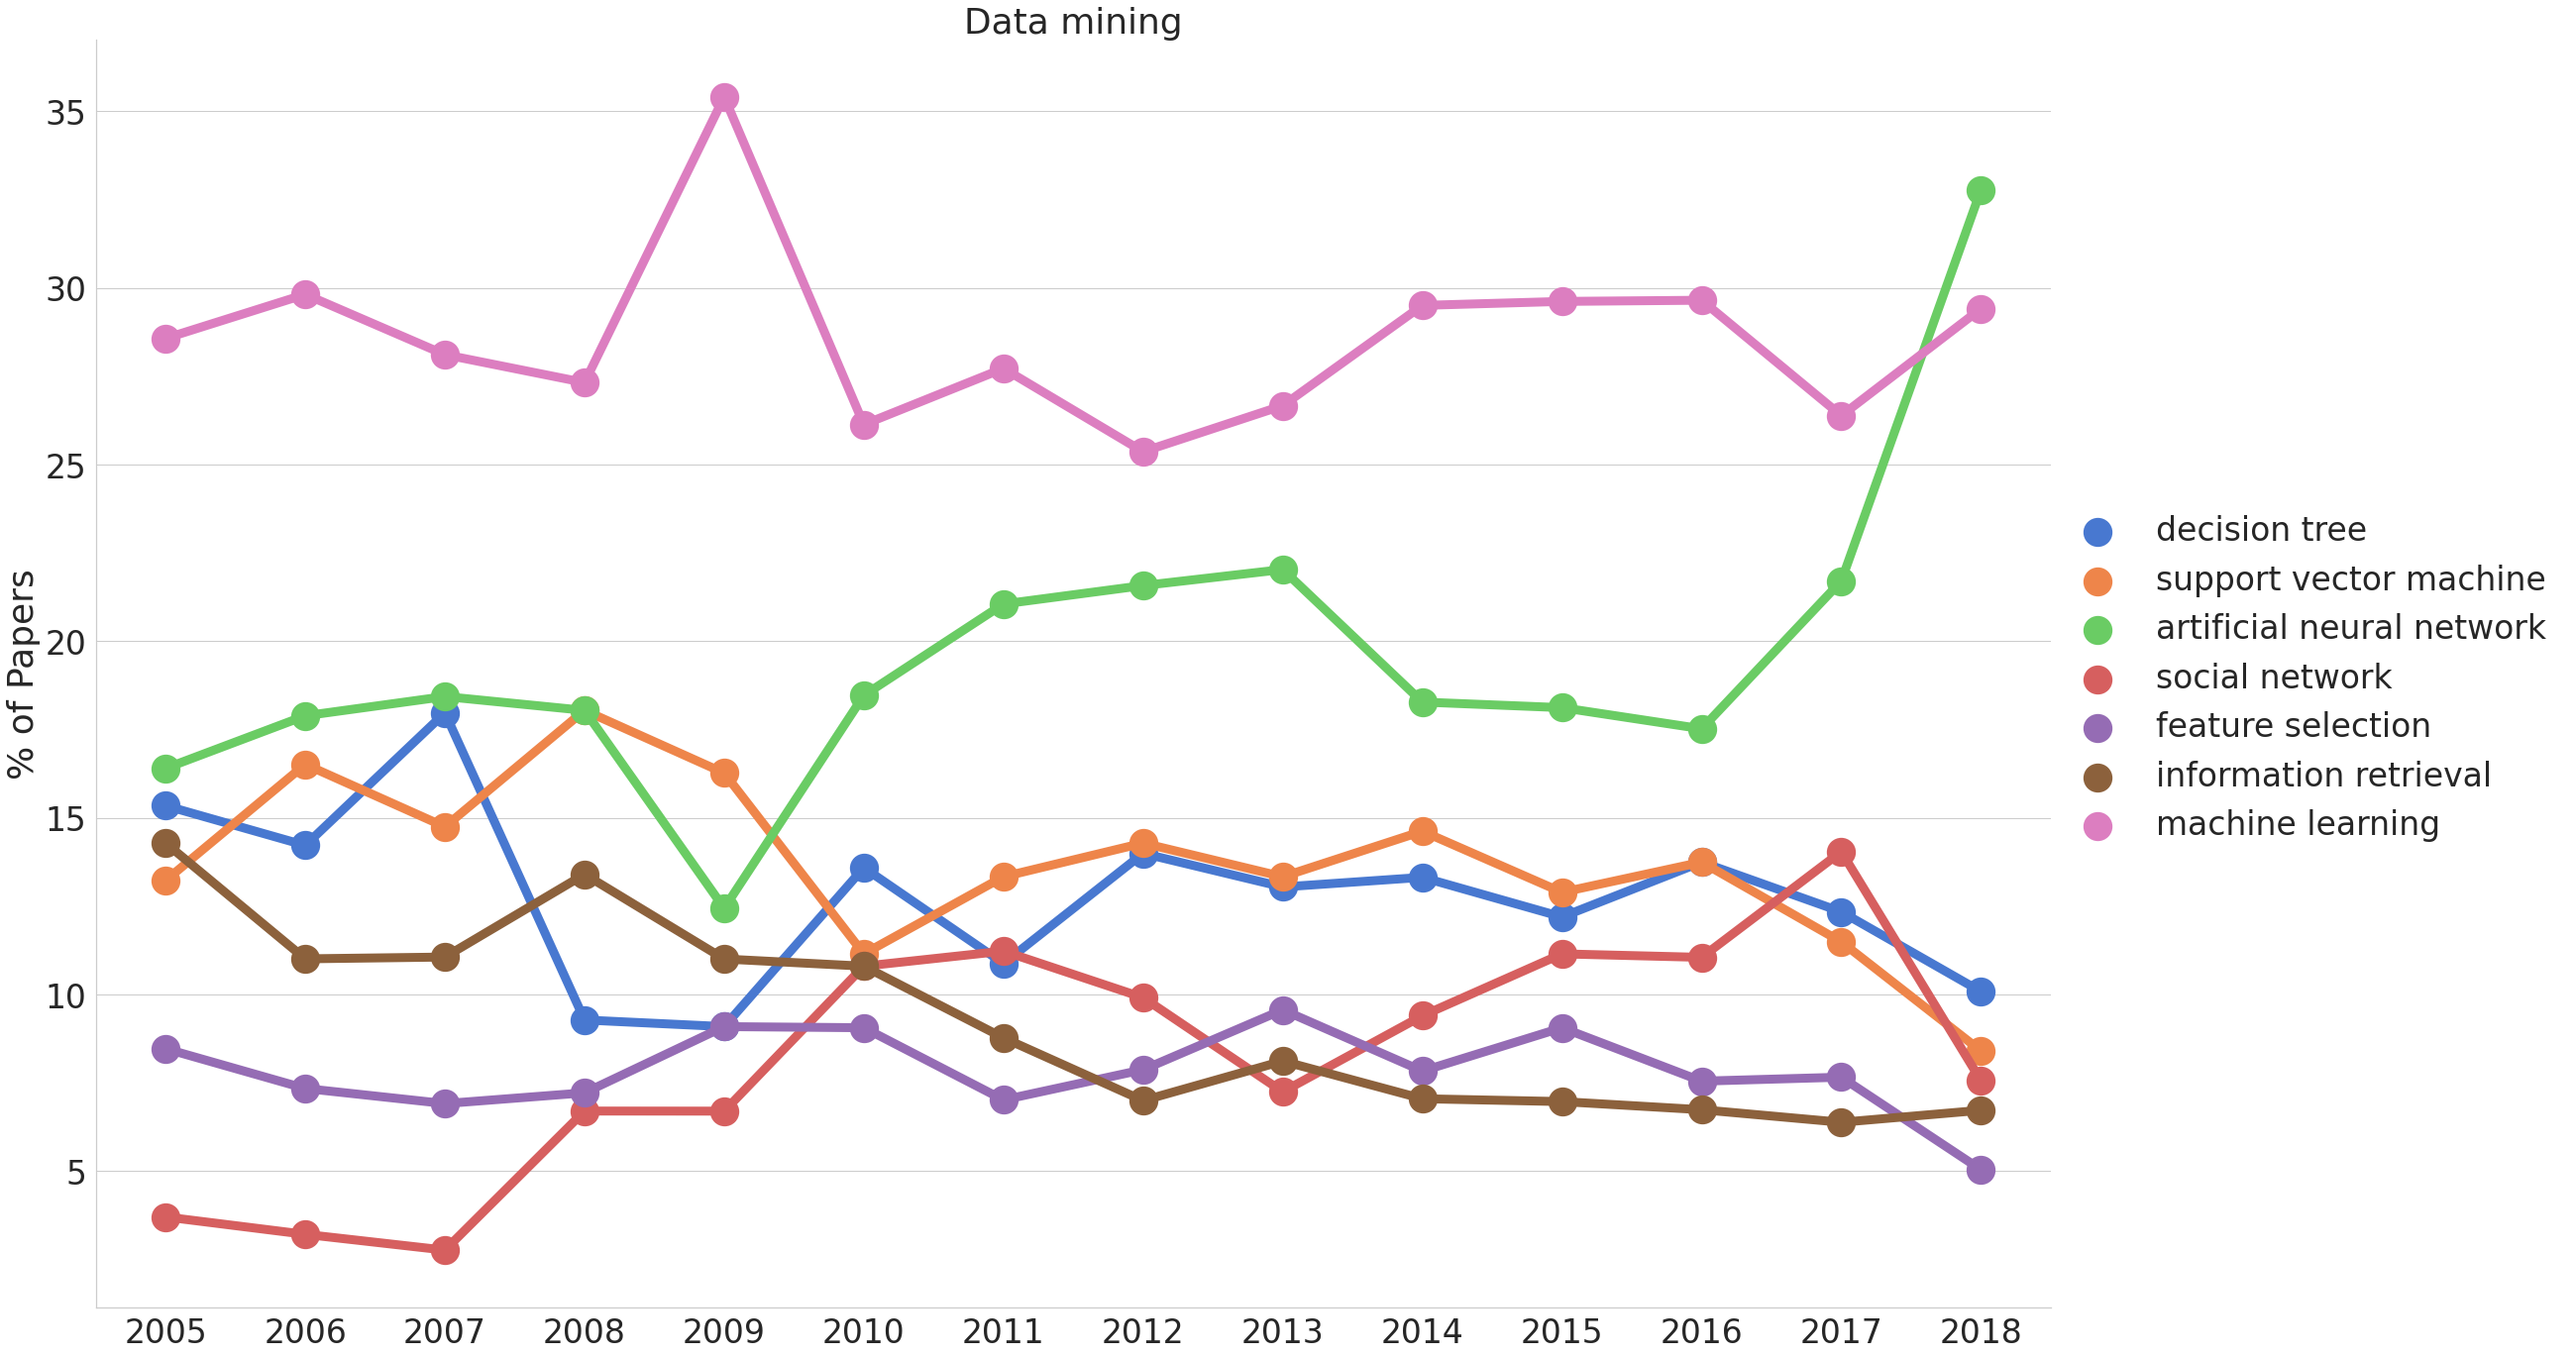

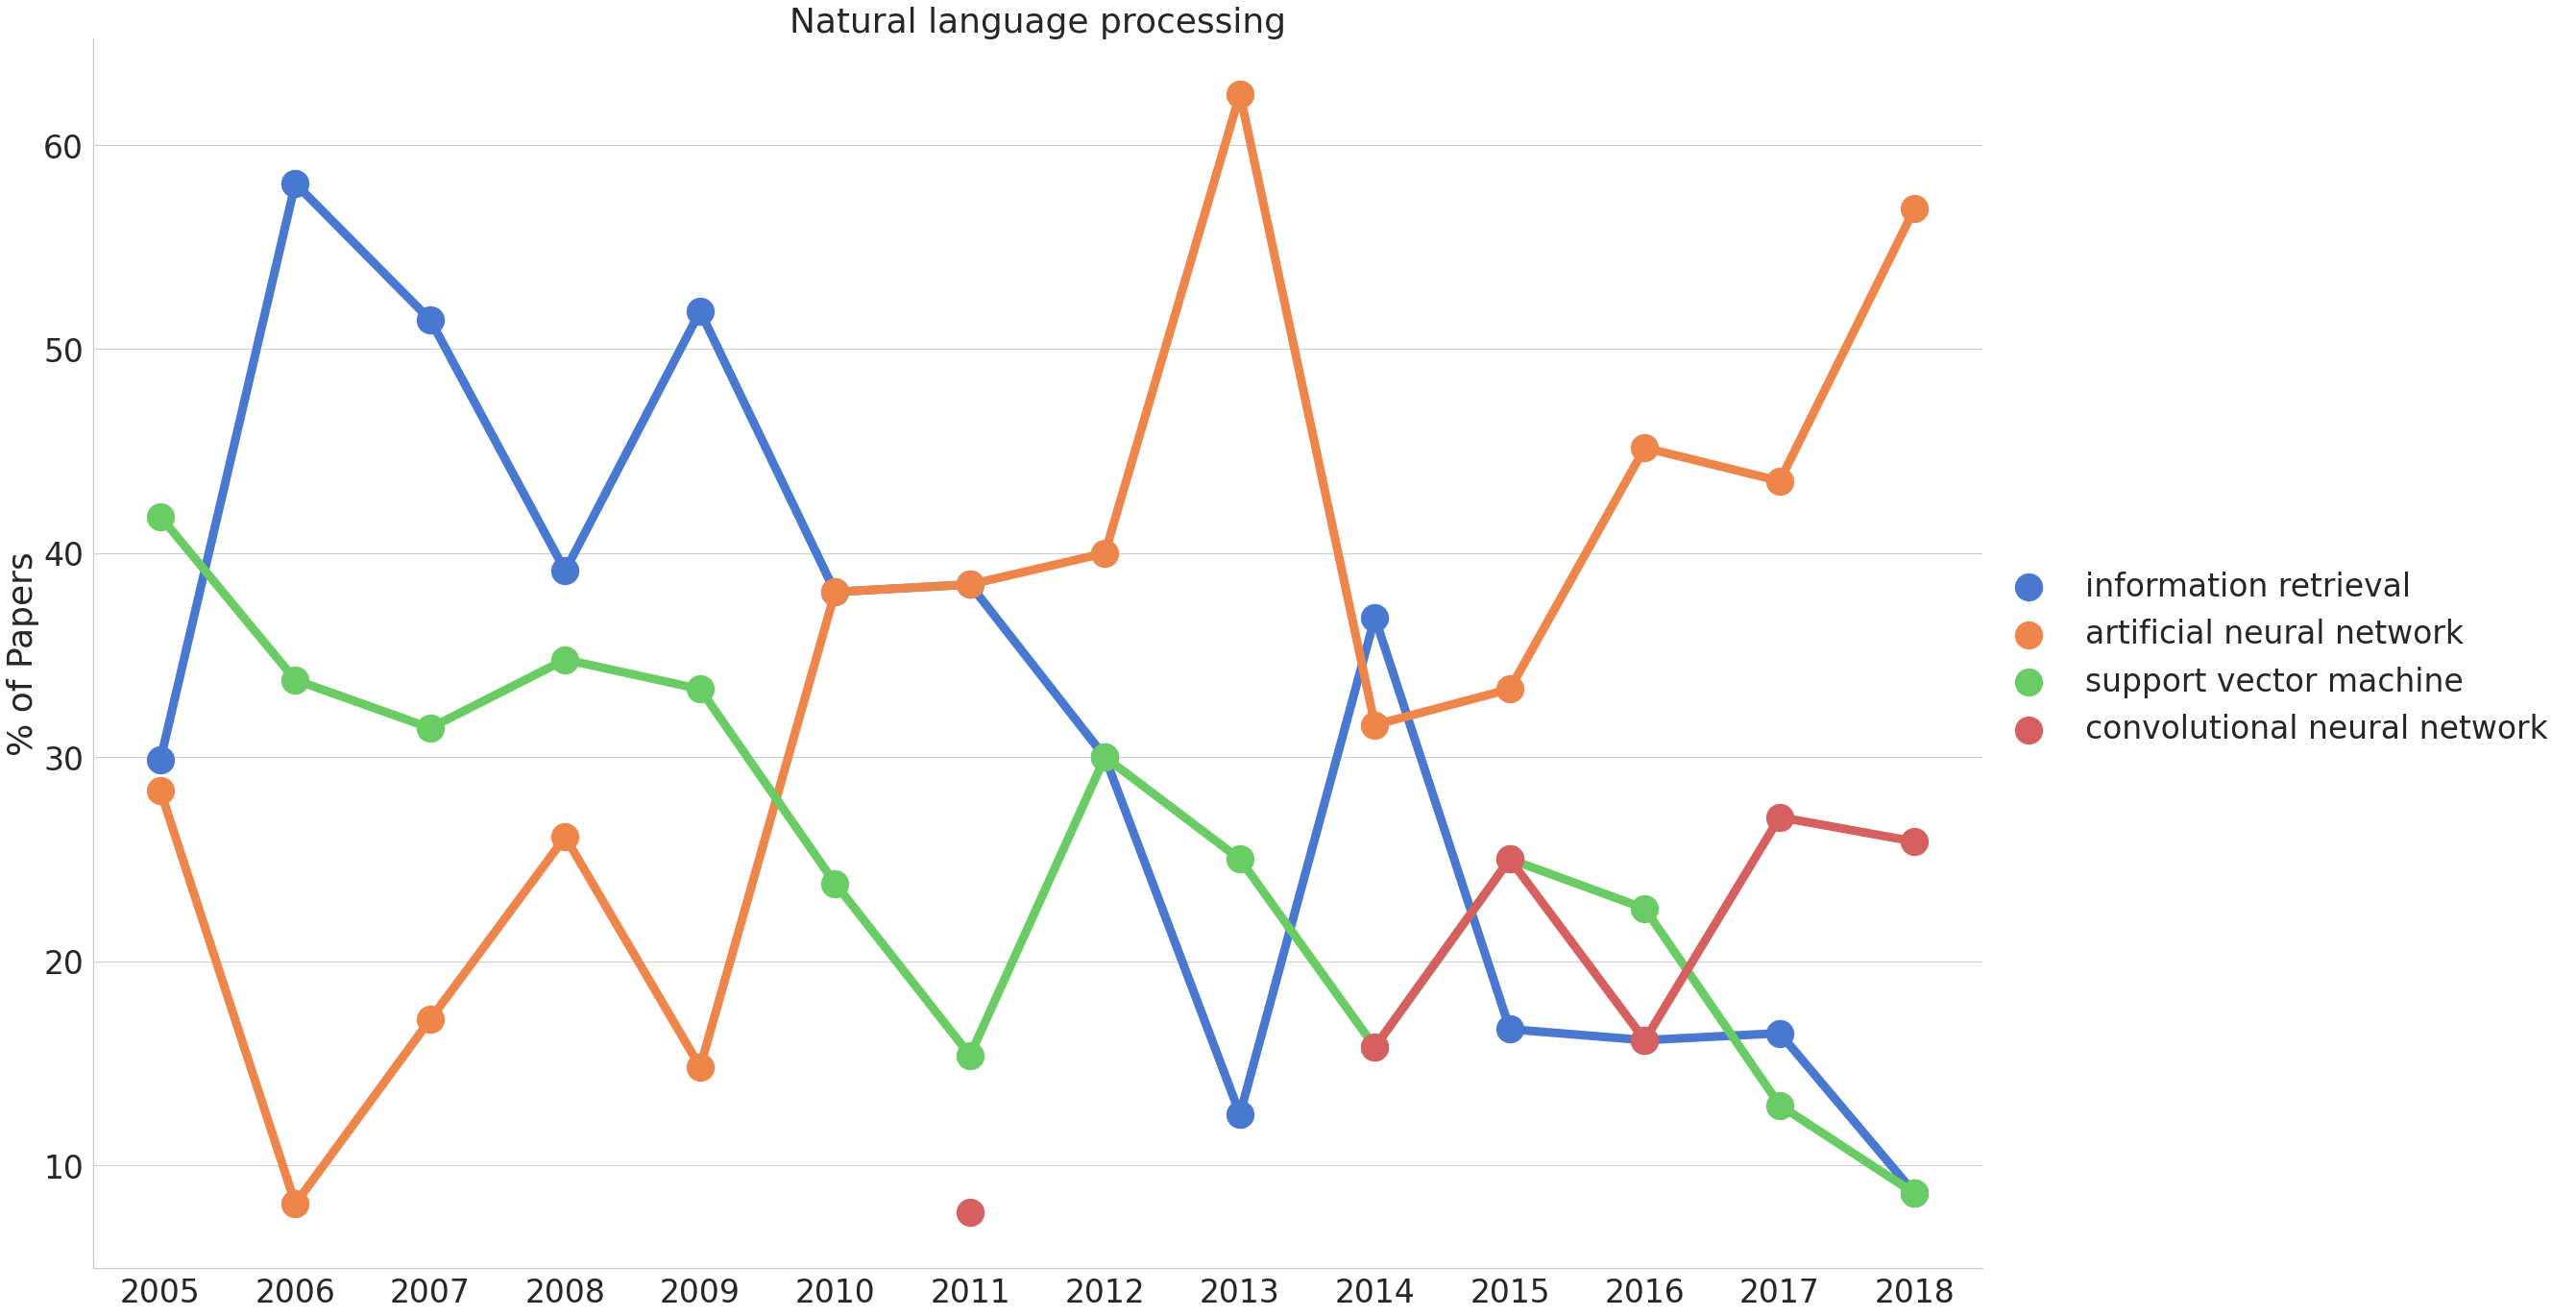

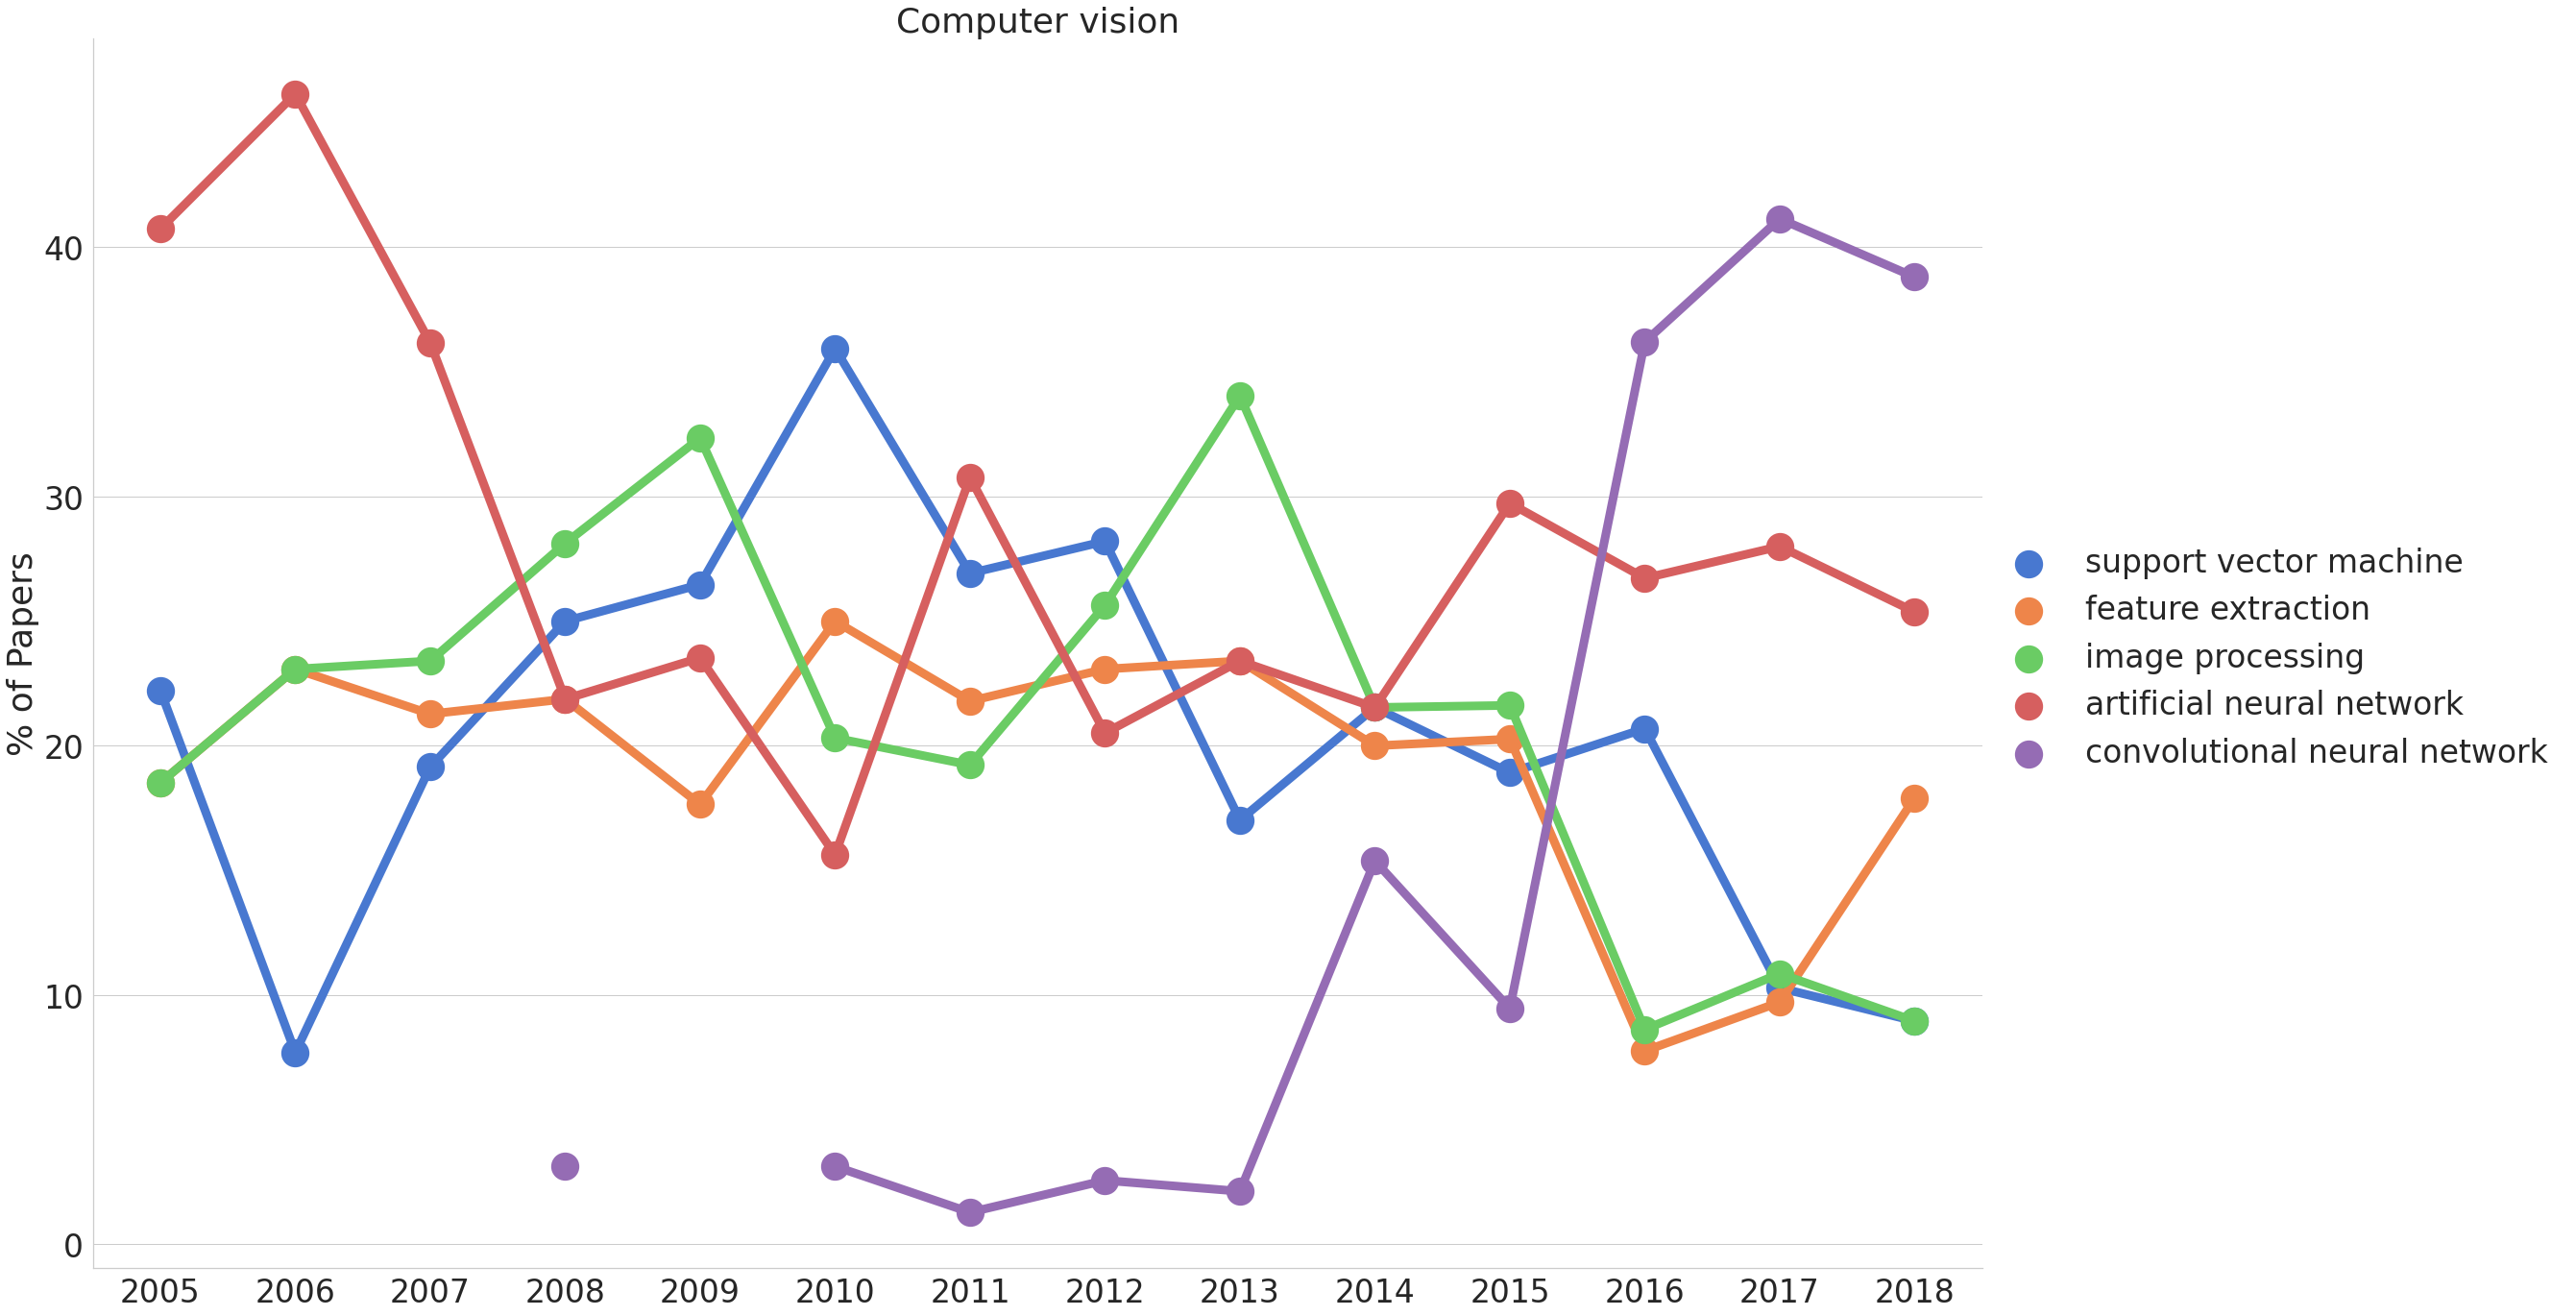

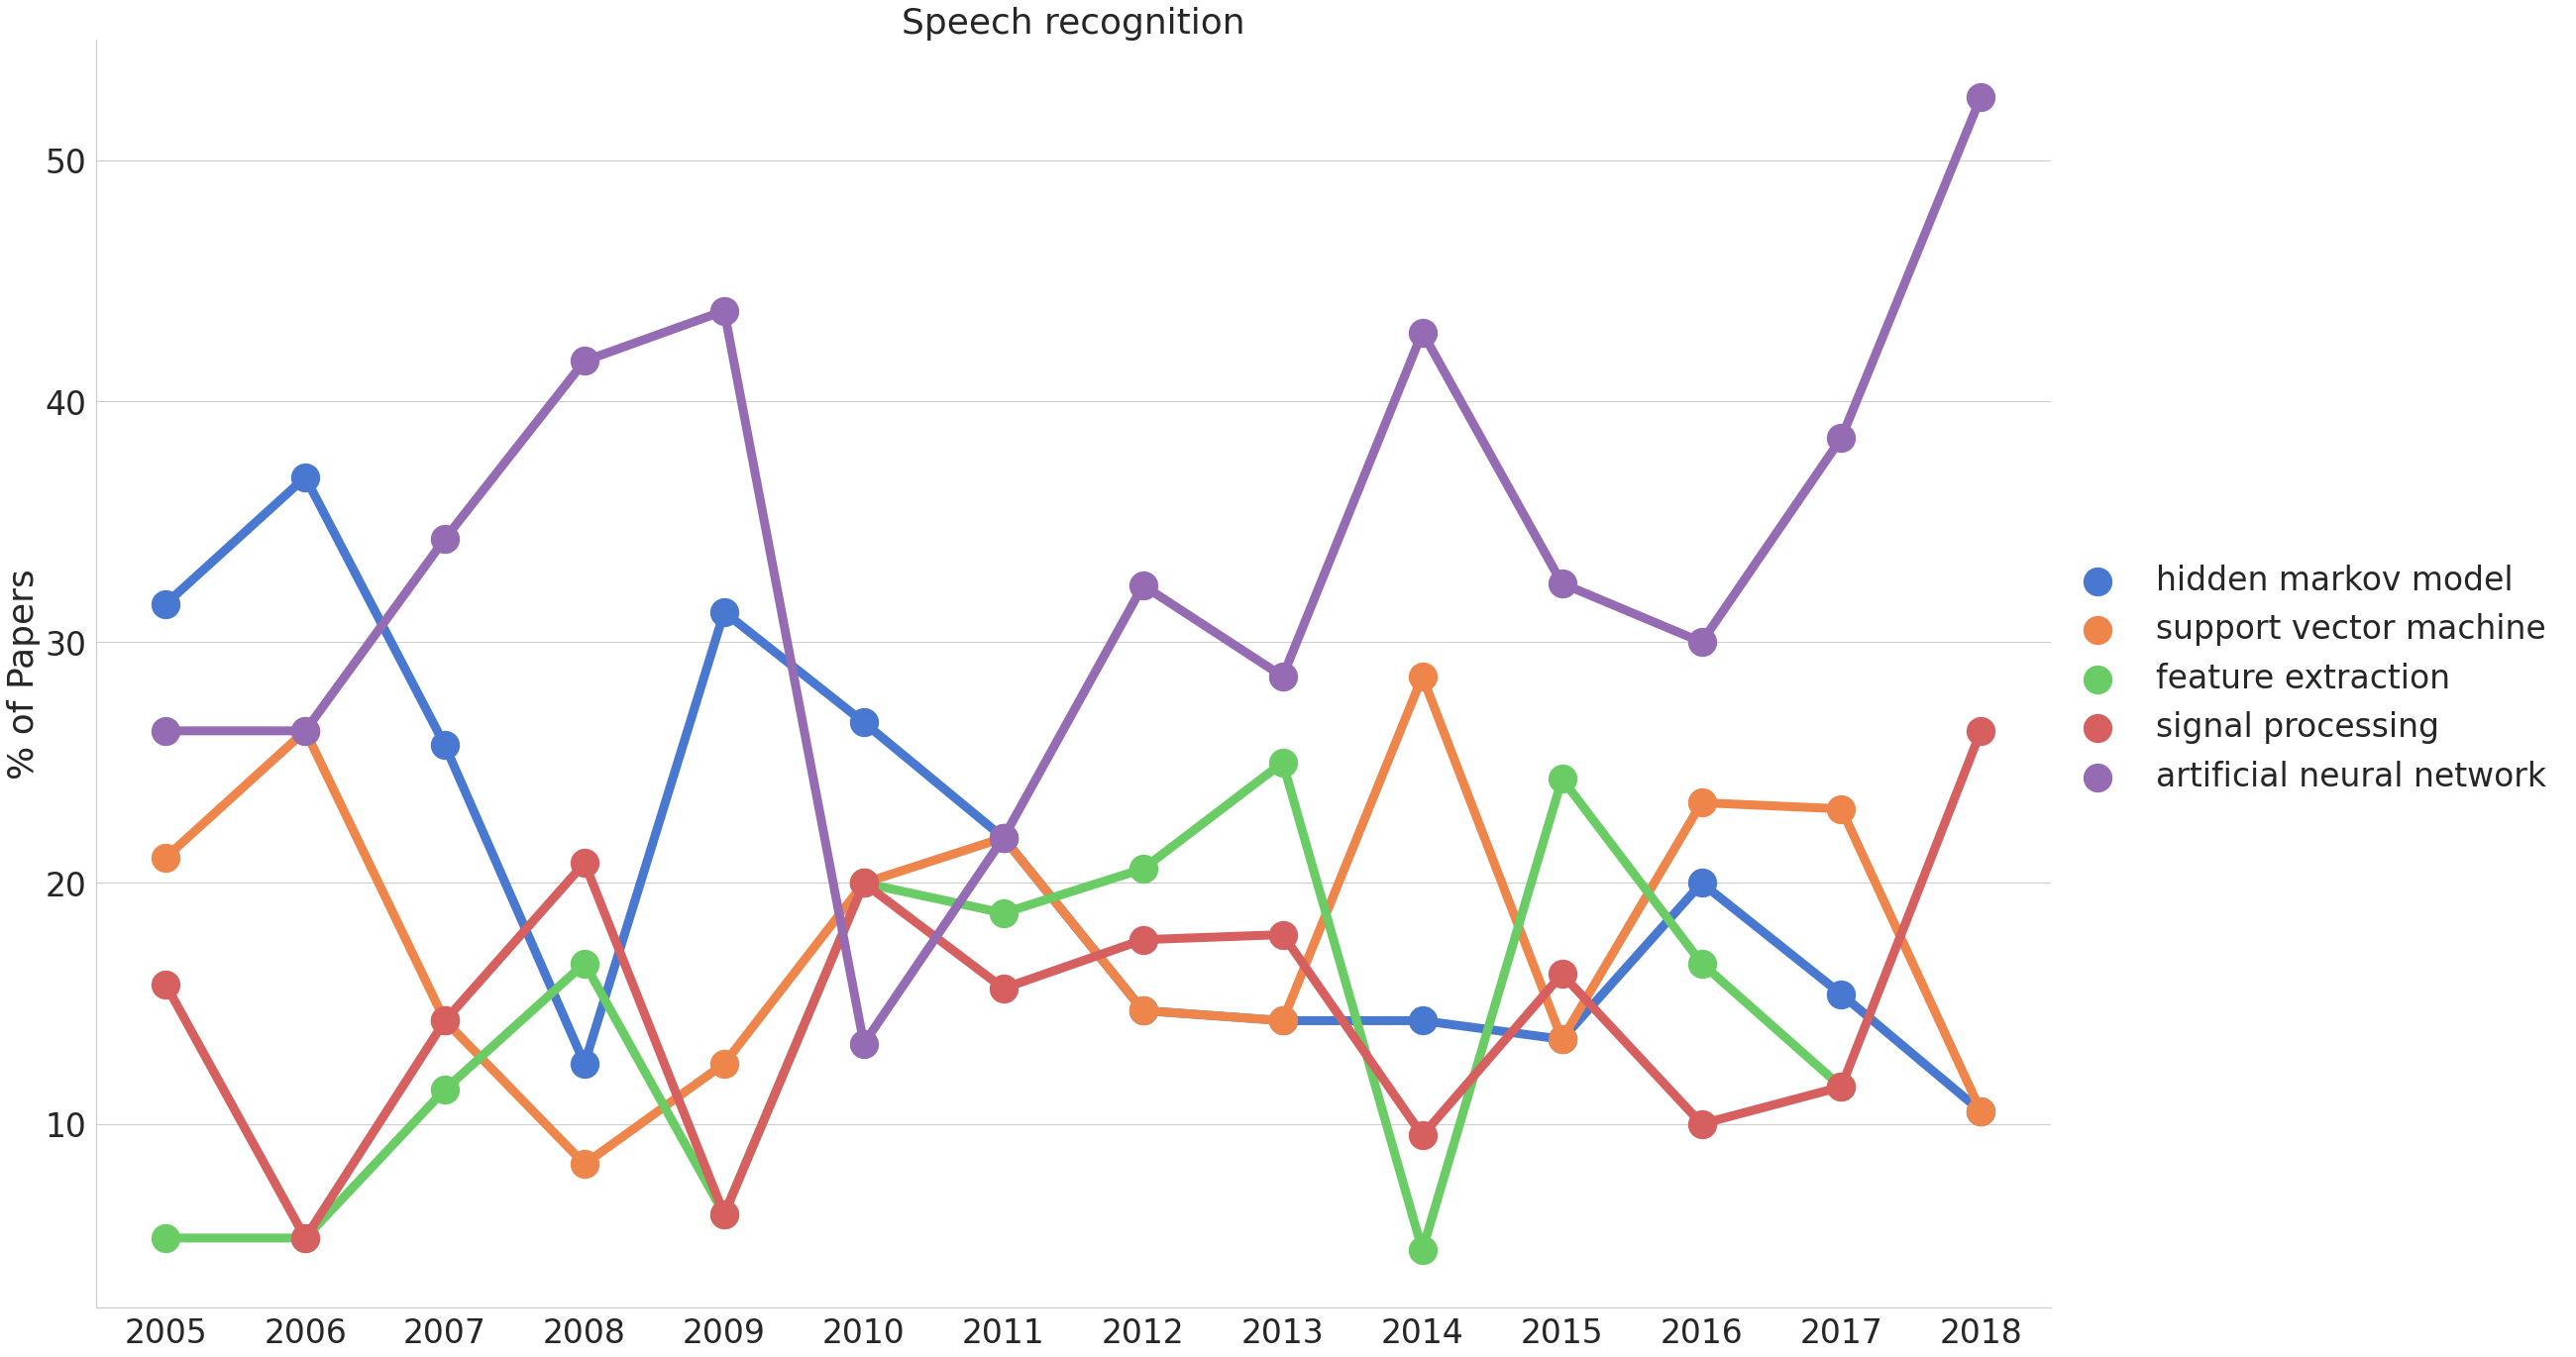

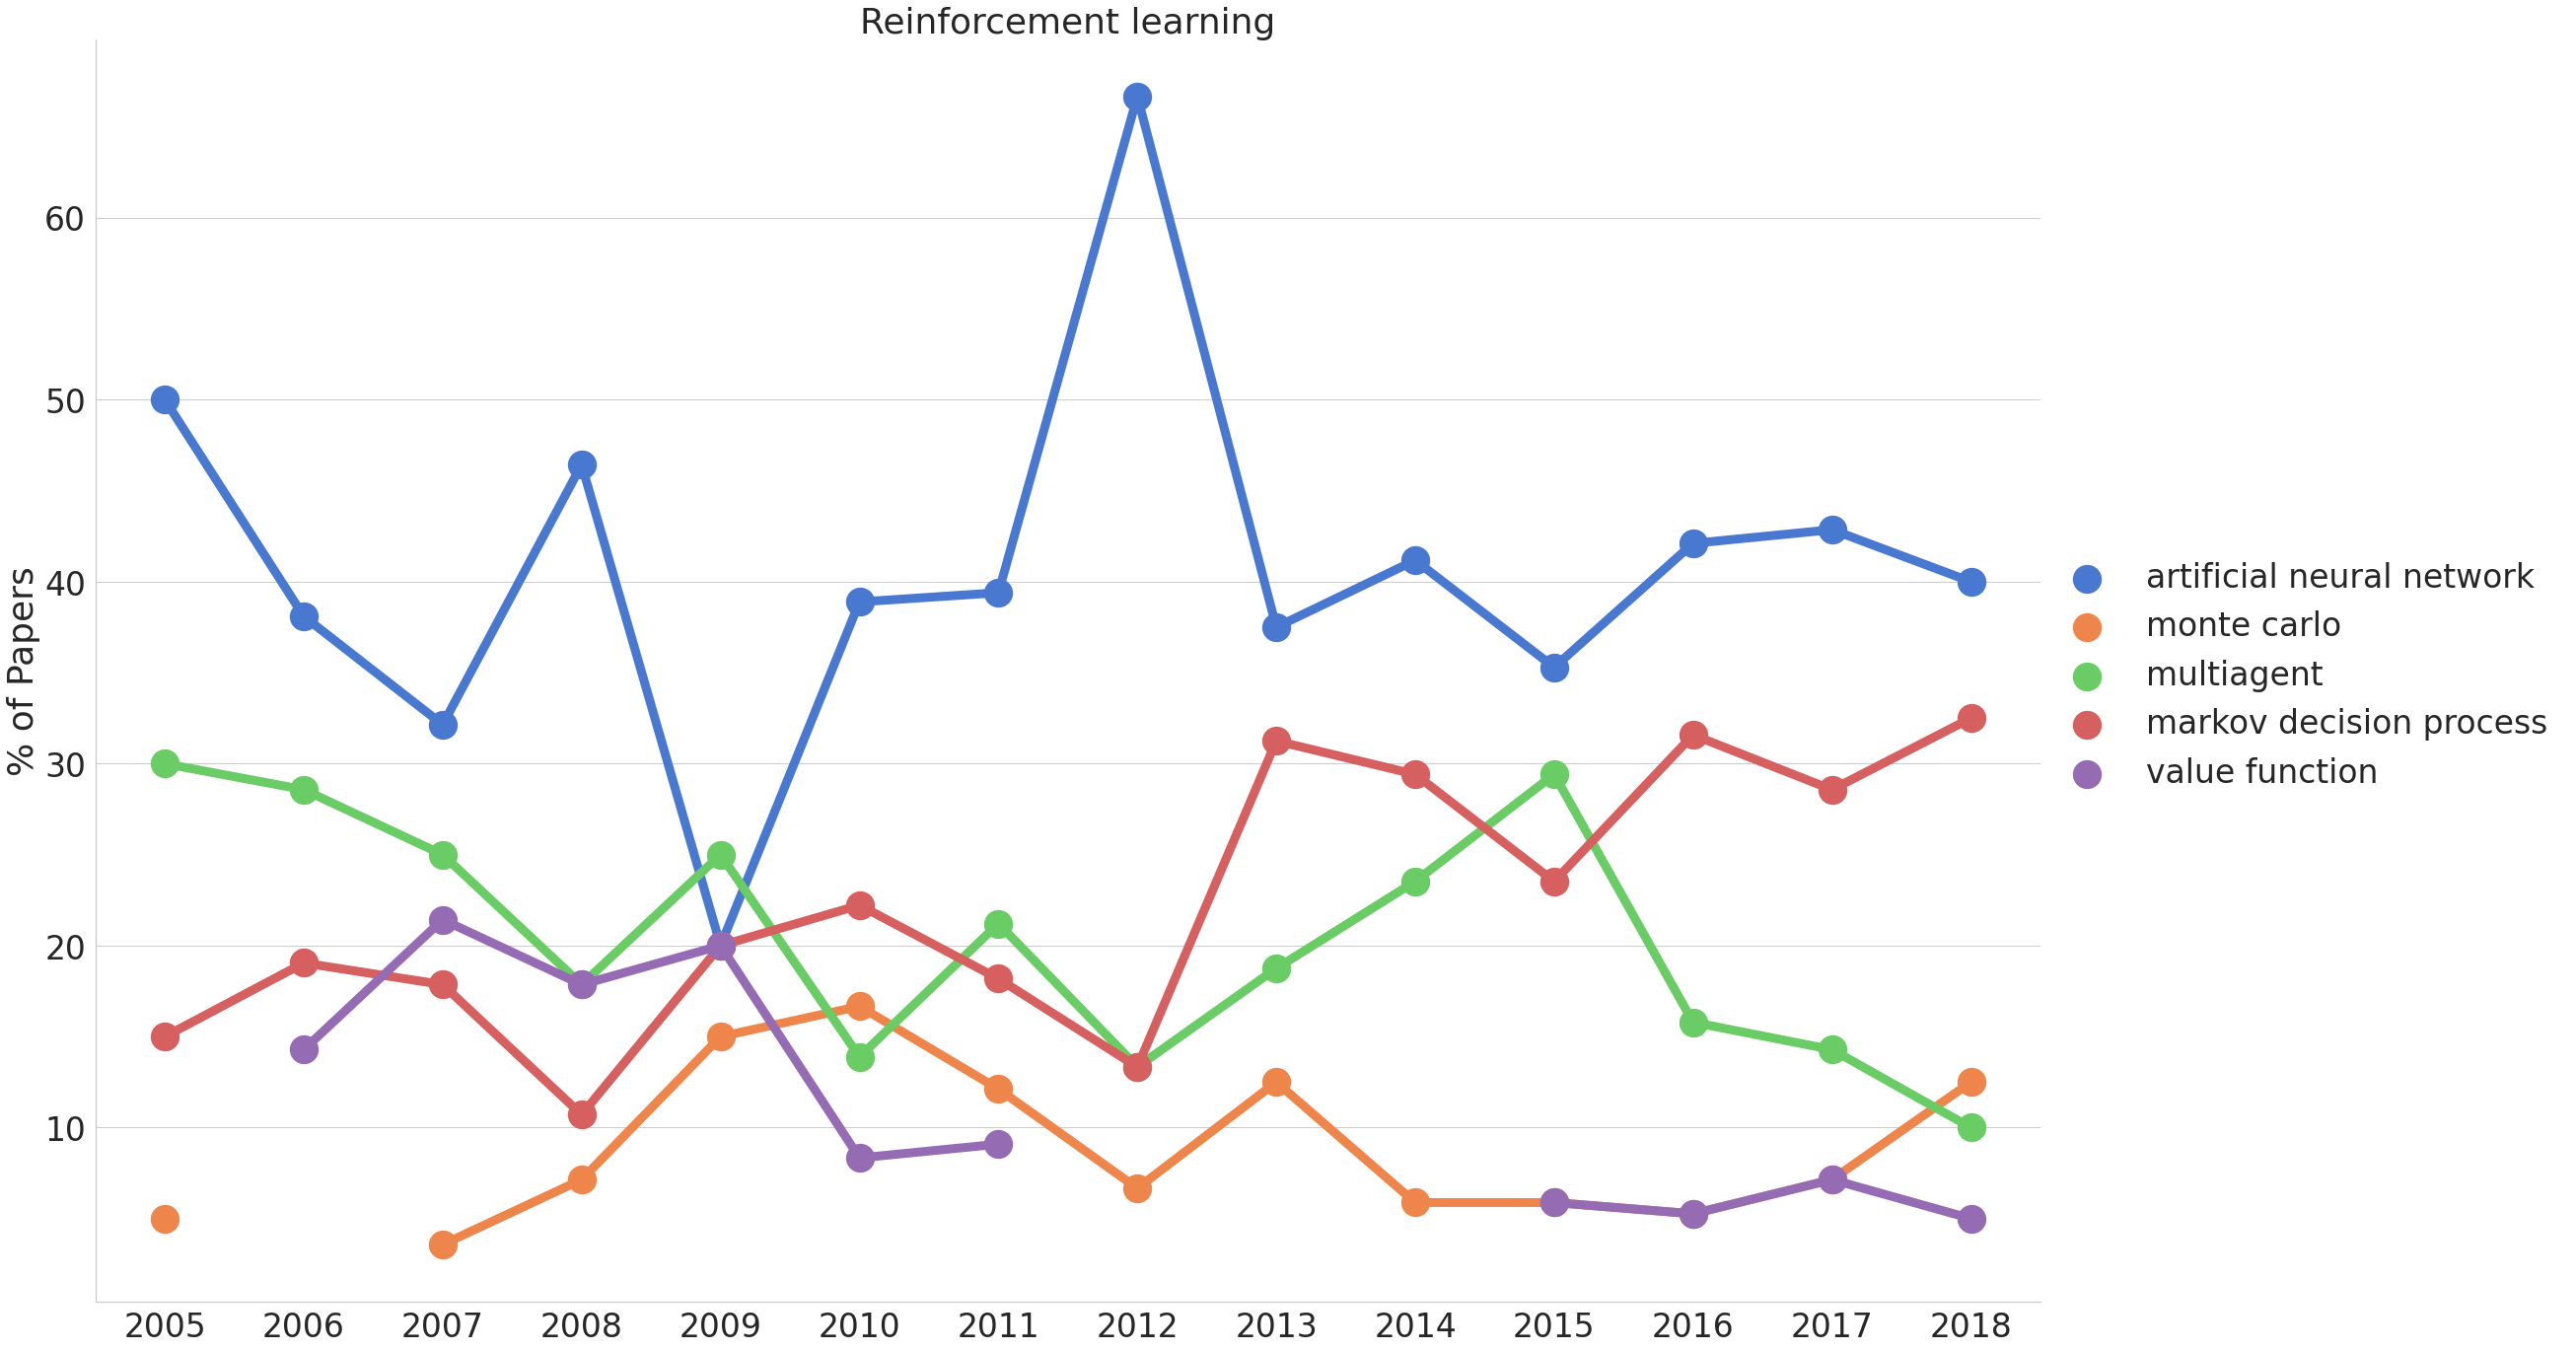

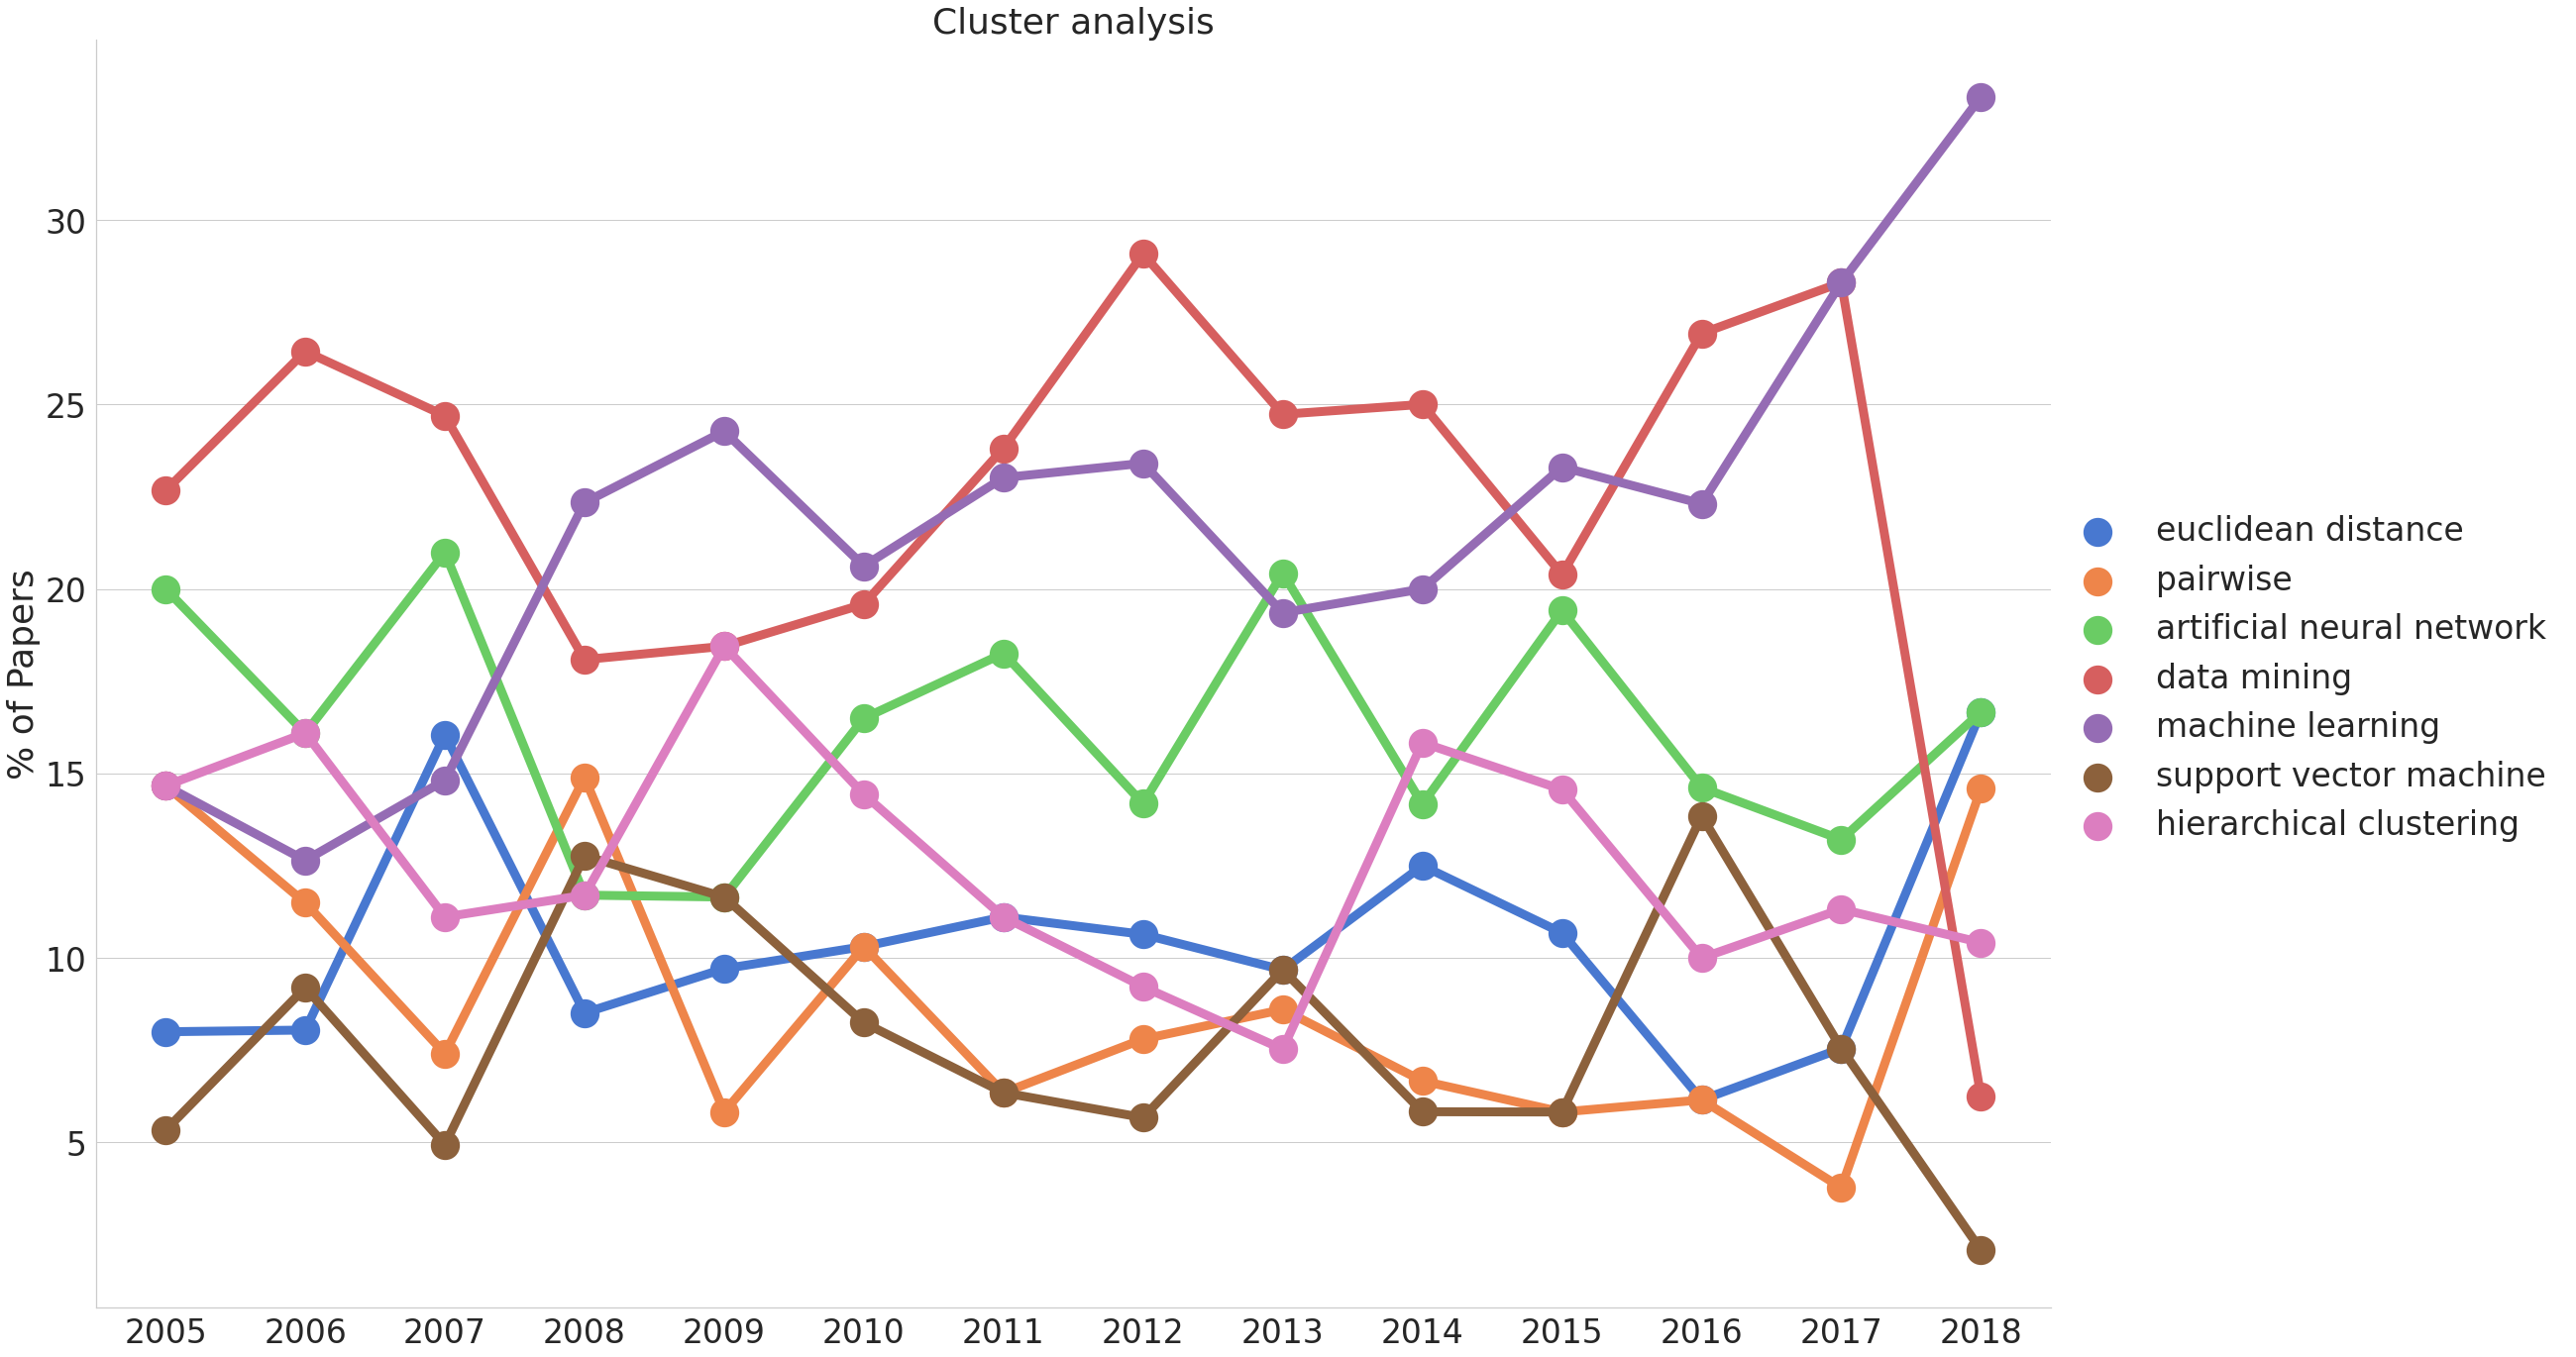

In [18]:
topics = ['Pattern recognition', 'Data mining', 'Natural language processing', 'Computer vision',
          'Speech recognition', 'Reinforcement learning', 'Cluster analysis']
topic_methods = [
    ['artificial neural network', 'support vector machine', 'decision tree', 'feature space'],
    ['artificial neural network', 'support vector machine', 'decision tree', 'feature selection', 'information retrieval', 'social network', 'machine learning'],
    ['information retrieval', 'artificial neural network', 'support vector machine', 'convolutional neural network', 'bert'],
    ['artificial neural network', 'support vector machine', 'convolutional neural network', 'feature extraction', 'image processing'],
    ['artificial neural network', 'support vector machine', 'feature extraction', 'hidden markov model', 'signal processing'],
    ['artificial neural network', 'markov decision process', 'multiagent', 'value function', 'monte carlo', 'deep reinforcement leanrning'],
    ['machine learning', 'data mining', 'artificial neural network', 'support vector machine', 'euclidean distance', 'pairwise', 'hierarchical clustering']
]
for topic, topic_methods in zip(topics, topic_methods):
    documents = fos[fos['field_of_study'] == topic].drop(['field_of_study', 'count'], axis=1)
    documents = documents.merge(entities_years, on='document_id')
    
    # Show Word Cloud
    #wc = WordCloud(background_color="white", width=2000, height=1000)
    #wc.generate(' '.join(documents['method'].values))
    #plt.figure(figsize=(20, 10))
    #plt.axis('off')
    #plt.imshow(wc)
    #plt.show()
    
    # Plot count over years
    years = documents.drop('method', axis=1).drop_duplicates(subset='document_id', keep="first").drop('document_id', axis=1).groupby(['published_year']).sum().reset_index()
    #years.plot(x='published_year', y='count', figsize=(20, 10), title=topic)
    #sns.set(style="whitegrid", rc={"lines.linewidth": 2})
    #g = sns.lineplot(x="published_year", y="count", data=years, markers=True)
    
    # Select top entities over years
    df2 = documents.drop('document_id', axis=1).groupby(['method', 'published_year']).sum().reset_index().sort_values('published_year')
    #top_methods = df2.drop('published_year', axis=1).groupby('method').sum().reset_index()
    #top_methods = top_methods[top_methods['method'].str.lower() != topic.lower()]
    #top_methods = top_methods.sort_values('count', ascending=False)
    #data = top_methods[:10].merge(df2, how='left', on='method').drop('count_x', axis=1).rename(columns={'count_y': 'count'})
    #data = data.groupby('method').sum().reset_index()
    
    data = df2[df2['method'].isin(topic_methods)]
    data = data.merge(years, on='published_year')
    data['count_rel'] = data['count_x'] / data['count_y'] * 100
        
    # Plot used entities over years
    sns.set(style="whitegrid", font_scale=3, rc={"lines.linewidth": 5})
    g = sns.catplot(x="published_year", y="count_rel", hue="method", data=data,
                    kind="point", height=20, aspect=1.5, palette=sns.color_palette("muted"))
    g.set_axis_labels("", "% of Papers")
    g.set(title=topic)
    g._legend.set_title("")

In [60]:
topic = "Pattern recognition"
documents = fos[fos['field_of_study'] == topic].drop(['field_of_study', 'count'], axis=1)
documents = documents.merge(entities_years, on='document_id')
documents

document_id                          method  published_year  count
0           728297                  computer aided            2013      1
1           728297                     data mining            2013      1
2           728297                         genetic            2013      1
3           728297                machine learning            2013      1
4           728297          support vector machine            2013      1
...            ...                             ...             ...    ...
55483   2890442302  canonical correlation analysis            2018      1
55484   2890546378   medical segmentation datasets            2018      1
55485   2890546378             deep neural network            2018      1
55486   2890546378                   deep learning            2018      1
55487   2890546378                machine learning            2018      1

[55488 rows x 4 columns]

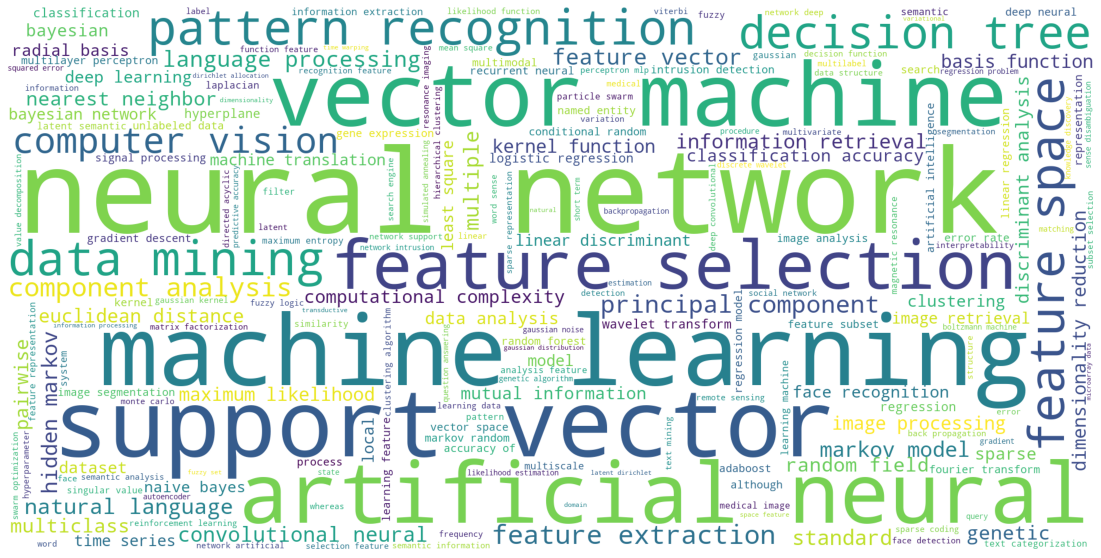

In [61]:
wc = WordCloud(background_color="white", width=2000, height=1000)
wc.generate(' '.join(documents['method'].values))
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(wc)
plt.show()

published_year  count
0             2005    405
1             2006    444
2             2007    472
3             2008    402
4             2009    432
5             2010    404
6             2011    368
7             2012    386
8             2013    289
9             2014    320
10            2015    305
11            2016    414
12            2017    382
13            2018    213

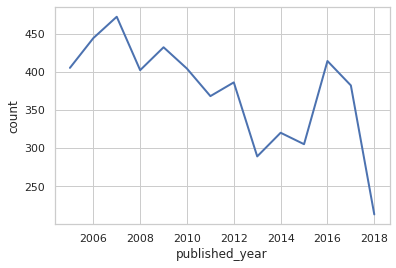

In [62]:
#documents = documents[documents['published_year'] < 2018]
years = documents.drop('method', axis=1).drop_duplicates(subset='document_id', keep="first").drop('document_id', axis=1).groupby(['published_year']).sum().reset_index()
sns.set(style="whitegrid", rc={"lines.linewidth": 2})
g = sns.lineplot(x="published_year", y="count", data=years, markers=True)
years
#g.set_axis_labels("", "# Papers")

In [63]:
df2 = documents.drop('document_id', axis=1).groupby(['method', 'published_year']).sum().reset_index().sort_values('published_year')
#df2 = df2[df2['count'] >= 5]
df2

method  published_year  count
4710    dirichlet priors stand            2005      1
6677    feature representation            2005      6
2077            categorization            2005      2
13884              mexican hat            2005      1
13881               metropolis            2005      1
...                        ...             ...    ...
21309        spectral analysis            2018      1
13493        mean square error            2018      3
694         arbitrary division            2018      1
5673                      esom            2018      1
5079   document image analysis            2018      2

[24446 rows x 3 columns]

In [64]:
top_methods = df2.drop('published_year', axis=1).groupby('method').sum().reset_index()
top_methods = top_methods.sort_values('count', ascending=False)
top_methods[:200]

method  count
6909                    machine learning   1403
515            artificial neural network   1184
12231             support vector machine   1115
9261                 pattern recognition    651
3865                       feature space    635
3833                   feature selection    599
2224                         data mining    592
1835                     computer vision    584
2397                       decision tree    531
3733                  feature extraction    486
8493         natural language processing    422
3923                      feature vector    403
8556                    nearest neighbor    332
7788                          multiclass    327
9556        principal component analysis    316
9107                            pairwise    315
5479               information retrieval    309
5000                 hidden markov model    309
2002        convolutional neural network    304
3352                  euclidean distance    303
1766            computational complexity    301
4610                             genetic    299
2713            dimensionality reduction    298
5860                     kernel function    288
5327                    image processing    286
3565                    face recognition    248
2466                       deep learning    241
5179                          hyperplane    234
1493             classification accuracy    233
8352                  mutual information    228
2166                       data analysis    209
6934                 machine translation    208
8392                         naive bayes    198
872                     bayesian network    190
501              artificial intelligence    190
7139                  maximum likelihood    189
9926               radial basis function    187
5339                     image retrieval    175
3315                          error rate    172
11166                  signal processing    172
12626                        time series    169
10022                      random forest    165
71                              adaboost    165
5347                  image segmentation    164
12221                     support vector    156
1902            conditional random field    156
1729                  component analysis    155
2485                 deep neural network    154
6454        linear discriminant analysis    151
7943                          multimodal    150
2855                        discriminant    145
5461              information extraction    142
12888                     unlabeled data    142
6342                        least square    140
6812                 logistic regression    138
5261                      image analysis    133
10231           recurrent neural network    132
9555                 principal component    125
13186                  wavelet transform    125
1625                clustering algorithm    124
7039                 markov random field    122
8004                            multiple    119
3892                      feature subset    119
12446                text categorization    117
3826              feature representation    115
9340                          perceptron    115
4785                    gradient descent    112
7895               multilayer perceptron    109
8194                          multiscale    108
6111                           laplacian    104
4547                     gene expression    104
2280                      data structure    101
2355                   decision function    101
10378             reinforcement learning    100
12470                        text mining     99
4154                   fourier transform     97
5610                    interpretability     97
11537              sparse representation     97
11255       singular value decomposition     96
688                      backpropagation     96
3533                      face detection     95
4305                         fuzzy logic     94
8439                        named entity     93
65

### Select subset of entities

In [65]:
top_methods[:10].merge(df2, how='left', on='method').drop('count_x', axis=1).rename(columns={'count_y': 'count'})

method  published_year  count
0             machine learning            2005     96
1             machine learning            2006    102
2             machine learning            2007     97
3             machine learning            2008    117
4             machine learning            2009     81
5             machine learning            2010     95
6             machine learning            2011    119
7             machine learning            2012    105
8             machine learning            2013     90
9             machine learning            2014    101
10            machine learning            2015     98
11            machine learning            2016    123
12            machine learning            2017    119
13            machine learning            2018     60
14   artificial neural network            2005     59
15   artificial neural network            2006     77
16   artificial neural network            2007    114
17   artificial neural network            2008     70
18   artificial neural network            2009     64
19   artificial neural network            2010     74
20   artificial neural network            2011     86
21   artificial neural network            2012     94
22   artificial neural network            2013     80
23   artificial neural network            2014     75
24   artificial neural network            2015     85
25   artificial neural network            2016    110
26   artificial neural network            2017    127
27   artificial neural network            2018     69
28      support vector machine            2005     78
29      support vector machine            2006     96
30      support vector machine            2007     93
31      support vector machine            2008    104
32      support vector machine            2009     79
33      support vector machine            2010     81
34      support vector machine            2011     86
35      support vector machine            2012     80
36      support vector machine            2013     66
37      support vector machine            2014     80
38      support vector machine            2015     74
39      support vector machine            2016     92
40      support vector machine            2017     75
41      support vector machine            2018     31
42         pattern recognition            2005     33
43         pattern recognition            2006     43
44         pattern recognition            2007     60
45         pattern recognition            2008     46
46         pattern recognition            2009     38
47         pattern recognition            2010     67
48         pattern recognition            2011     64
49         pattern recognition            2012     77
50         pattern recognition            2013     40
51         pattern recognition            2014     59
52         pattern recognition            2015     40
53         pattern recognition            2016     36
54         pattern recognition            2017     33
55         pattern recognition            2018     15
56               feature space            2005     49
57               feature space            2006     64
58               feature space            2007     49
59               feature space            2008     50
60               feature space            2009     44
61               feature space            2010     56
62               feature space            2011     48
63               feature space            2012     57
64               feature space            2013     39
65               feature space            2014     51
66               feature space            2015     30
67               feature space            2016     39
68               feature space            2017     42
69               feature space            2018     17
70           feature selection            2005     36
71           feature selection            2006     47
72           feature selection            2007     53
73           feature selecti

In [66]:
entities = ["artificial neural network", "support vector machine", "random forest",
            "decision tree", "neurest neighbor", "logistic regression", "naive bayes"]
data = df2[df2['method'].isin(entities)]
data = data.merge(years, on='published_year')
data['count_rel'] = data['count_x'] / data['count_y'] * 100
df2[df2['method'].str.contains('|'.join(entities), regex=True)].drop('published_year', axis=1).groupby('method').sum().sort_values('count', ascending=False)[:200]
#data.groupby('method').sum().sort_values('count', ascending=False)

count
method                                                   
artificial neural network                            1184
support vector machine                               1115
decision tree                                         531
naive bayes                                           198
random forest                                         165
logistic regression                                   138
logistic regression model                              26
multiple decision trees                                 9
kernel logistic regression                              7
standard support vector machine                         6
standard decision tree                                  6
sparse logistic regression                              6
fuzzy support vector machine                            5
multinomial logistic regression                         5
decision trees dt                                       5
classifiers decision tree                               4
naive bayesian classification                           4
recurrent artificial neural network                     4
structured support vector machine                       3
support vector machine classification                   3
artificial neural networks nn                           3
random decision tree                                    3
pairwise support vector machine                         2
standard naive bayes                                    2
logistic regression problem                             2
logistic regression formulation                         2
penalized logistic regression                           2
logistic regression function                            2
regression support vector machine                       2
kernel support vector machine                           2
support vector machine network                          2
naive bayesian nb                                       2
hidden naive bayes                                      2
support vector machinerecursive feature elimina...      2
support vector machine recursive feature elimin...      2
multiclass logistic regression                          2
artificial neural network nn                            2
multilayer artificial neural network                    2
although random forest                                  2
though support vector machine                           2
weighted support vector machine                         2
support vector machine support vector machine           2
multiple support vector machines svms                   1
random forest complete case analysis                    1
multivariate decision tree                              1
perceptron decision tree                                1
radial basis kernel random forests                      1
multiple logistic regression model                      1
proximity support vector machine                        1
proximal support vector machine                         1
predictive accuracy of the naive bayesian               1
polynomial support vector machine                       1
random forest random forest                             1
multivariate gauss naive bayes                          1
naive bayesian learning                                 1
naive bayes batch                                       1
naive bayesian text classification                      1
naive bayesian modeling                                 1
random forest regression model                          1
naive bayesian classification model                     1
naive bayes net                                         1
naive bayesian network structure                        1
naive bayesian tc                                       1
naive bayes nearest neighbor                            1
naive bayes learning                                    1
naive bayes naïve bayes                                 1
naive bayes models                                      1
particle swarm optimization support vector mach...

### Plot number of documents which used a specific entity over time

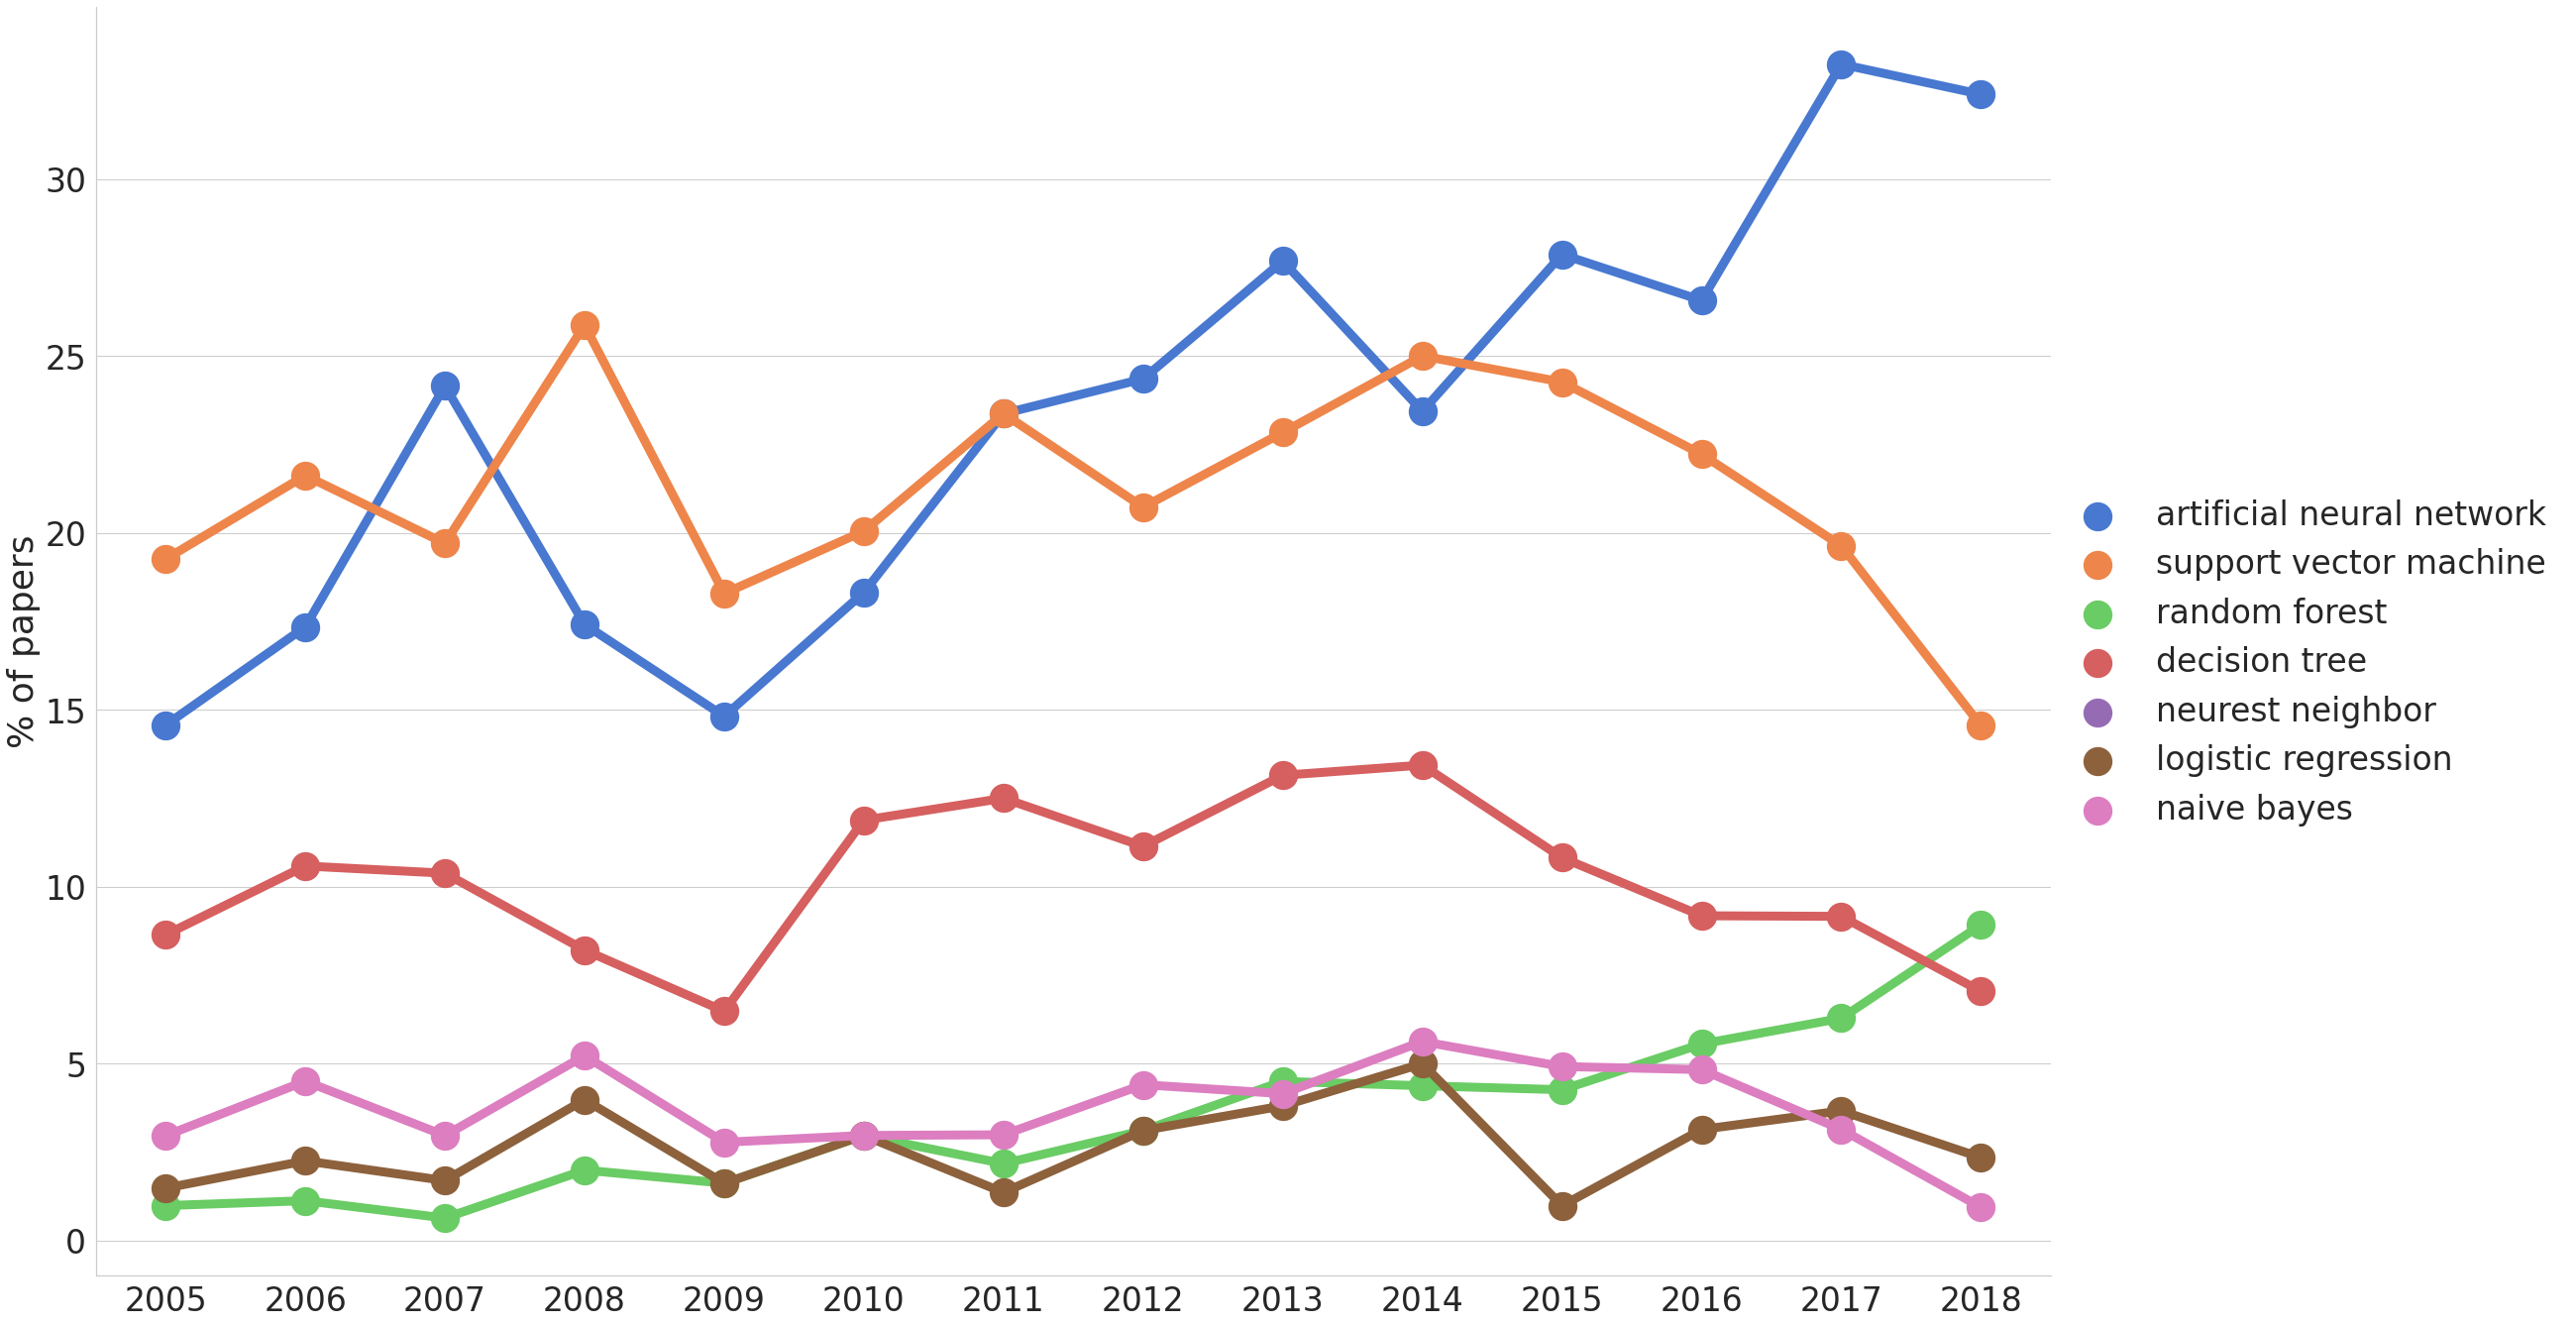

In [67]:
data = data.sort_values('method')
sns.set(style="whitegrid", font_scale=3, rc={"lines.linewidth": 5})
g = sns.catplot(x="published_year", y="count_rel", hue="method", data=data,
                kind="point", height=20, aspect=1.5, palette=sns.color_palette("muted"), hue_order=entities)
g.set_axis_labels("", "% of papers")
g._legend.set_title("")

# Computer vision

In [68]:
topic = "Computer vision"
documents = fos[fos['field_of_study'] == topic].drop(['field_of_study', 'count'], axis=1)
documents = documents.merge(entities_years, on='document_id')

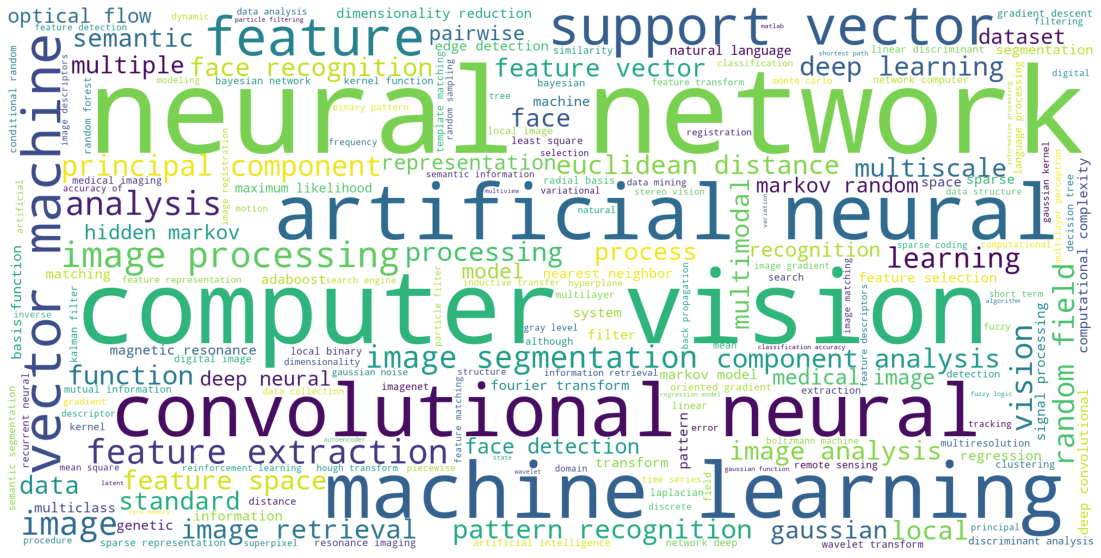

In [69]:
wc = WordCloud(background_color="white", width=2000, height=1000)
wc.generate(' '.join(documents['method'].values))
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(wc)
plt.show()

published_year  count
0             2005     78
1             2006     67
2             2007     90
3             2008     95
4             2009     72
5             2010    143
6             2011    142
7             2012    140
8             2013    105
9             2014    132
10            2015    108
11            2016    167
12            2017    179
13            2018     70

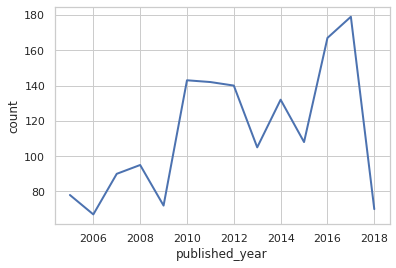

In [70]:
#documents = documents[documents['published_year'] < 2018]
years = documents.drop('method', axis=1).drop_duplicates(subset='document_id', keep="first").drop('document_id', axis=1).groupby(['published_year']).sum().reset_index()
sns.set(style="whitegrid", rc={"lines.linewidth": 2})
g = sns.lineplot(x="published_year", y="count", data=years, markers=True)
years
#g.set_axis_labels("", "# Papers")

In [71]:
df2 = documents.drop('document_id', axis=1).groupby(['method', 'published_year']).sum().reset_index().sort_values('published_year')
#df2 = df2[df2['count'] >= 5]
df2

method  published_year  count
2140  evolved neural controllers exploited active vi...            2005      1
5850                                    multiple filter            2005      1
5902                                multiple processors            2005      1
5909                                  multiple semantic            2005      1
5911                                 multiple sentences            2005      1
...                                                 ...             ...    ...
8030                                       social media            2018      1
3386                                               gsnn            2018      1
8038                                     social network            2018      3
7983                                              smaid            2018      1
2088                                         error term            2018      1

[9181 rows x 3 columns]

In [72]:
top_methods = df2.drop('published_year', axis=1).groupby('method').sum().reset_index()
top_methods = top_methods.sort_values('count', ascending=False)
top_methods[:200]

method  count
655                     computer vision    478
205           artificial neural network    249
2701                   machine learning    231
4766             support vector machine    184
2115                   image processing    171
709        convolutional neural network    164
1460                 feature extraction    162
2135                 image segmentation    137
3650                pattern recognition    135
894                       deep learning    129
1507                      feature space    124
1259                 euclidean distance    118
1377                   face recognition    115
2127                    image retrieval    109
1523                     feature vector     95
3769       principal component analysis     88
2059                     image analysis     87
3115                         multimodal     85
3221                         multiscale     83
1343                     face detection     82
3584                           pairwise     77
611            computational complexity     75
3529                       optical flow     75
903                 deep neural network     71
1015           dimensionality reduction     69
1501                  feature selection     69
2751                markov random field     68
3351                   nearest neighbor     66
23                             adaboost     65
1935                hidden markov model     61
1184                     edge detection     60
4370                  signal processing     59
883   deep convolutional neural network     53
3327        natural language processing     53
3047                         multiclass     52
197             artificial intelligence     50
3551                  oriented gradient     48
2717         magnetic resonance imaging     48
1781                            genetic     48
3936                      random forest     47
4024           recurrent neural network     46
3219                    multiresolution     46
2159                           imagenet     45
1611                  fourier transform     45
4270              semantic segmentation     43
4521              sparse representation     42
2875                      medical image     42
679            conditional random field     42
867                       decision tree     42
4812                  template matching     41
2886                    medical imaging     41
4098                     remote sensing     41
3768                principal component     40
2788                 maximum likelihood     39
3293                 mutual information     39
1448                feature descriptors     39
1496             feature representation     36
308                    bayesian network     36
2311                      kalman filter     36
2335                    kernel function     36
5107                  wavelet transform     35
2710                     machine vision     35
4084             reinforcement learning     34
3699                          piecewise     34
4481                      sparse coding     34
2414                          laplacian     34
594                  component analysis     34
805                         data mining     34
785                       data analysis     33
3080                         multilayer     33
2196              information retrieval     33
4248               semantic information     33
2524       linear discriminant analysis     33
2604                        local image     32
1734                     gaussian noise     32
1519                  feature transform     32
973                       digital image     32
1075                       discriminant     32
2033                         hyperplane     32
2097                     image gradient     30
1835                   gradient descent     30
3934                       random field     30
1721                    gaussian kernel     30
823                      data structure     29
2570               local binary patter

### Select subset of entities

In [73]:
top_methods[:10].merge(df2, how='left', on='method').drop('count_x', axis=1).rename(columns={'count_y': 'count'})

method  published_year  count
0                 computer vision            2005     22
1                 computer vision            2006     16
2                 computer vision            2007     23
3                 computer vision            2008     26
4                 computer vision            2009     19
5                 computer vision            2010     38
6                 computer vision            2011     35
7                 computer vision            2012     40
8                 computer vision            2013     22
9                 computer vision            2014     52
10                computer vision            2015     30
11                computer vision            2016     64
12                computer vision            2017     64
13                computer vision            2018     27
14      artificial neural network            2005     11
15      artificial neural network            2006     12
16      artificial neural network            2007     17
17      artificial neural network            2008      7
18      artificial neural network            2009      8
19      artificial neural network            2010     10
20      artificial neural network            2011     24
21      artificial neural network            2012     16
22      artificial neural network            2013     11
23      artificial neural network            2014     14
24      artificial neural network            2015     22
25      artificial neural network            2016     31
26      artificial neural network            2017     49
27      artificial neural network            2018     17
28               machine learning            2005      7
29               machine learning            2006      2
30               machine learning            2007     13
31               machine learning            2008     13
32               machine learning            2009      8
33               machine learning            2010     22
34               machine learning            2011     21
35               machine learning            2012     18
36               machine learning            2013     20
37               machine learning            2014     13
38               machine learning            2015     19
39               machine learning            2016     28
40               machine learning            2017     29
41               machine learning            2018     18
42         support vector machine            2005      6
43         support vector machine            2006      2
44         support vector machine            2007      9
45         support vector machine            2008      8
46         support vector machine            2009      9
47         support vector machine            2010     23
48         support vector machine            2011     21
49         support vector machine            2012     22
50         support vector machine            2013      8
51         support vector machine            2014     14
52         support vector machine            2015     14
53         support vector machine            2016     24
54         support vector machine            2017     18
55         support vector machine            2018      6
56               image processing            2005      5
57               image processing            2006      6
58               image processing            2007     11
59               image processing            2008      9
60               image processing            2009     11
61               image processing            2010     13
62               image processing            2011     15
63               image processing            2012     20
64               image processing            2013     16
65               image processing            2014     14
66               image processing            2015     16
67               image processing            2016     10
68               image processing            2017     19
69               image processing    

In [74]:
data.merge(years, on='published_year')

method  published_year  count_x  count_y  count_rel  \
0   artificial neural network            2011       86      368  23.369565   
1               decision tree            2011       46      368  12.500000   
2         logistic regression            2011        5      368   1.358696   
3                 naive bayes            2011       11      368   2.989130   
4               random forest            2011        8      368   2.173913   
5      support vector machine            2011       86      368  23.369565   
6   artificial neural network            2012       94      386  24.352332   
7               decision tree            2012       43      386  11.139896   
8         logistic regression            2012       12      386   3.108808   
9                 naive bayes            2012       17      386   4.404145   
10              random forest            2012       12      386   3.108808   
11     support vector machine            2012       80      386  20.725389   
12  artificial neural network            2013       80      289  27.681661   
13              decision tree            2013       38      289  13.148789   
14        logistic regression            2013       11      289   3.806228   
15                naive bayes            2013       12      289   4.152249   
16              random forest            2013       13      289   4.498270   
17     support vector machine            2013       66      289  22.837370   
18  artificial neural network            2009       64      432  14.814815   
19              decision tree            2009       28      432   6.481481   
20        logistic regression            2009        7      432   1.620370   
21                naive bayes            2009       12      432   2.777778   
22              random forest            2009        7      432   1.620370   
23     support vector machine            2009       79      432  18.287037   
24  artificial neural network            2006       77      444  17.342342   
25              decision tree            2006       47      444  10.585586   
26        logistic regression            2006       10      444   2.252252   
27                naive bayes            2006       20      444   4.504505   
28              random forest            2006        5      444   1.126126   
29     support vector machine            2006       96      444  21.621622   
30  artificial neural network            2014       75      320  23.437500   
31              decision tree            2014       43      320  13.437500   
32        logistic regression            2014       16      320   5.000000   
33                naive bayes            2014       18      320   5.625000   
34              random forest            2014       14      320   4.375000   
35     support vector machine            2014       80      320  25.000000   
36  artificial neural network            2007      114      472  24.152542   
37              decision tree            2007       49      472  10.381356   
38        logistic regression            2007        8      472   1.694915   
39                naive bayes            2007       14      472   2.966102   
40              random forest            2007        3      472   0.635593   
41     support vector machine            2007       93      472  19.703390   
42  artificial neural network            2015       85      305  27.868852   
43              decision tree            2015       33      305  10.819672   
44        logistic regression            2015        3      305   0.983607   
45                naive bayes            2015       15      305   4.918033   
46              random forest            2015       13      305   4.262295   
47     support vector machine            2015       74      305  24.262295   
48  artificial neural network            2016      110      414  26.570048   
49              decision tree            2016       38      414   9.178744   
50        logistic regression            2016

In [75]:
entities = ['artificial neural network', 'support vector machine', 'convolutional neural network', 'principal component analysis']
            #'feature extraction', 'image segmentation', ]
data = df2[df2['method'].isin(entities)]
data = data.merge(years, on='published_year')
data['count_rel'] = data['count_x'] / data['count_y'] * 100
data
#df2[df2['method'].str.contains('|'.join(entities), regex=True)].drop('published_year', axis=1).groupby('method').sum().sort_values('count', ascending=False)[:200]
#data.groupby('method').sum().sort_values('count', ascending=False)

method  published_year  count_x  count_y  count_rel
0         support vector machine            2005        6       78   7.692308
1   principal component analysis            2005        6       78   7.692308
2      artificial neural network            2005       11       78  14.102564
3   principal component analysis            2006        4       67   5.970149
4         support vector machine            2006        2       67   2.985075
5      artificial neural network            2006       12       67  17.910448
6   principal component analysis            2007        7       90   7.777778
7      artificial neural network            2007       17       90  18.888889
8         support vector machine            2007        9       90  10.000000
9   principal component analysis            2008        6       95   6.315789
10     artificial neural network            2008        7       95   7.368421
11        support vector machine            2008        8       95   8.421053
12  convolutional neural network            2008        1       95   1.052632
13     artificial neural network            2009        8       72  11.111111
14        support vector machine            2009        9       72  12.500000
15  principal component analysis            2009        5       72   6.944444
16     artificial neural network            2010       10      143   6.993007
17        support vector machine            2010       23      143  16.083916
18  principal component analysis            2010        8      143   5.594406
19  convolutional neural network            2010        2      143   1.398601
20     artificial neural network            2011       24      142  16.901408
21  principal component analysis            2011       12      142   8.450704
22  convolutional neural network            2011        1      142   0.704225
23        support vector machine            2011       21      142  14.788732
24        support vector machine            2012       22      140  15.714286
25  principal component analysis            2012       13      140   9.285714
26  convolutional neural network            2012        2      140   1.428571
27     artificial neural network            2012       16      140  11.428571
28  convolutional neural network            2013        1      105   0.952381
29  principal component analysis            2013        6      105   5.714286
30     artificial neural network            2013       11      105  10.476190
31        support vector machine            2013        8      105   7.619048
32     artificial neural network            2014       14      132  10.606061
33  principal component analysis            2014        4      132   3.030303
34        support vector machine            2014       14      132  10.606061
35  convolutional neural network            2014       10      132   7.575758
36        support vector machine            2015       14      108  12.962963
37     artificial neural network            2015       22      108  20.370370
38  convolutional neural network            2015        7      108   6.481481
39  principal component analysis            2015        4      108   3.703704
40  convolutional neural network            2016       42      167  25.149701
41     artificial neural network            2016       31      167  18.562874
42  principal component analysis            2016        5      167   2.994012
43        support vector machine            2016       24      167  14.371257
44     artificial neural network            2017       49      179  27.374302
45        support vector machine            2017       18      179  10.055866
46  principal component analysis            2017        5      179   2.793296
47  convolutional neural network            2017       72      179  40.223464
48     artificial neural network            2018       17       70  24.285714
49  principal component analysis            2018        3       70   4.285714
50        support vector machine            2018

### Plot number of documents which used a specific entity over time

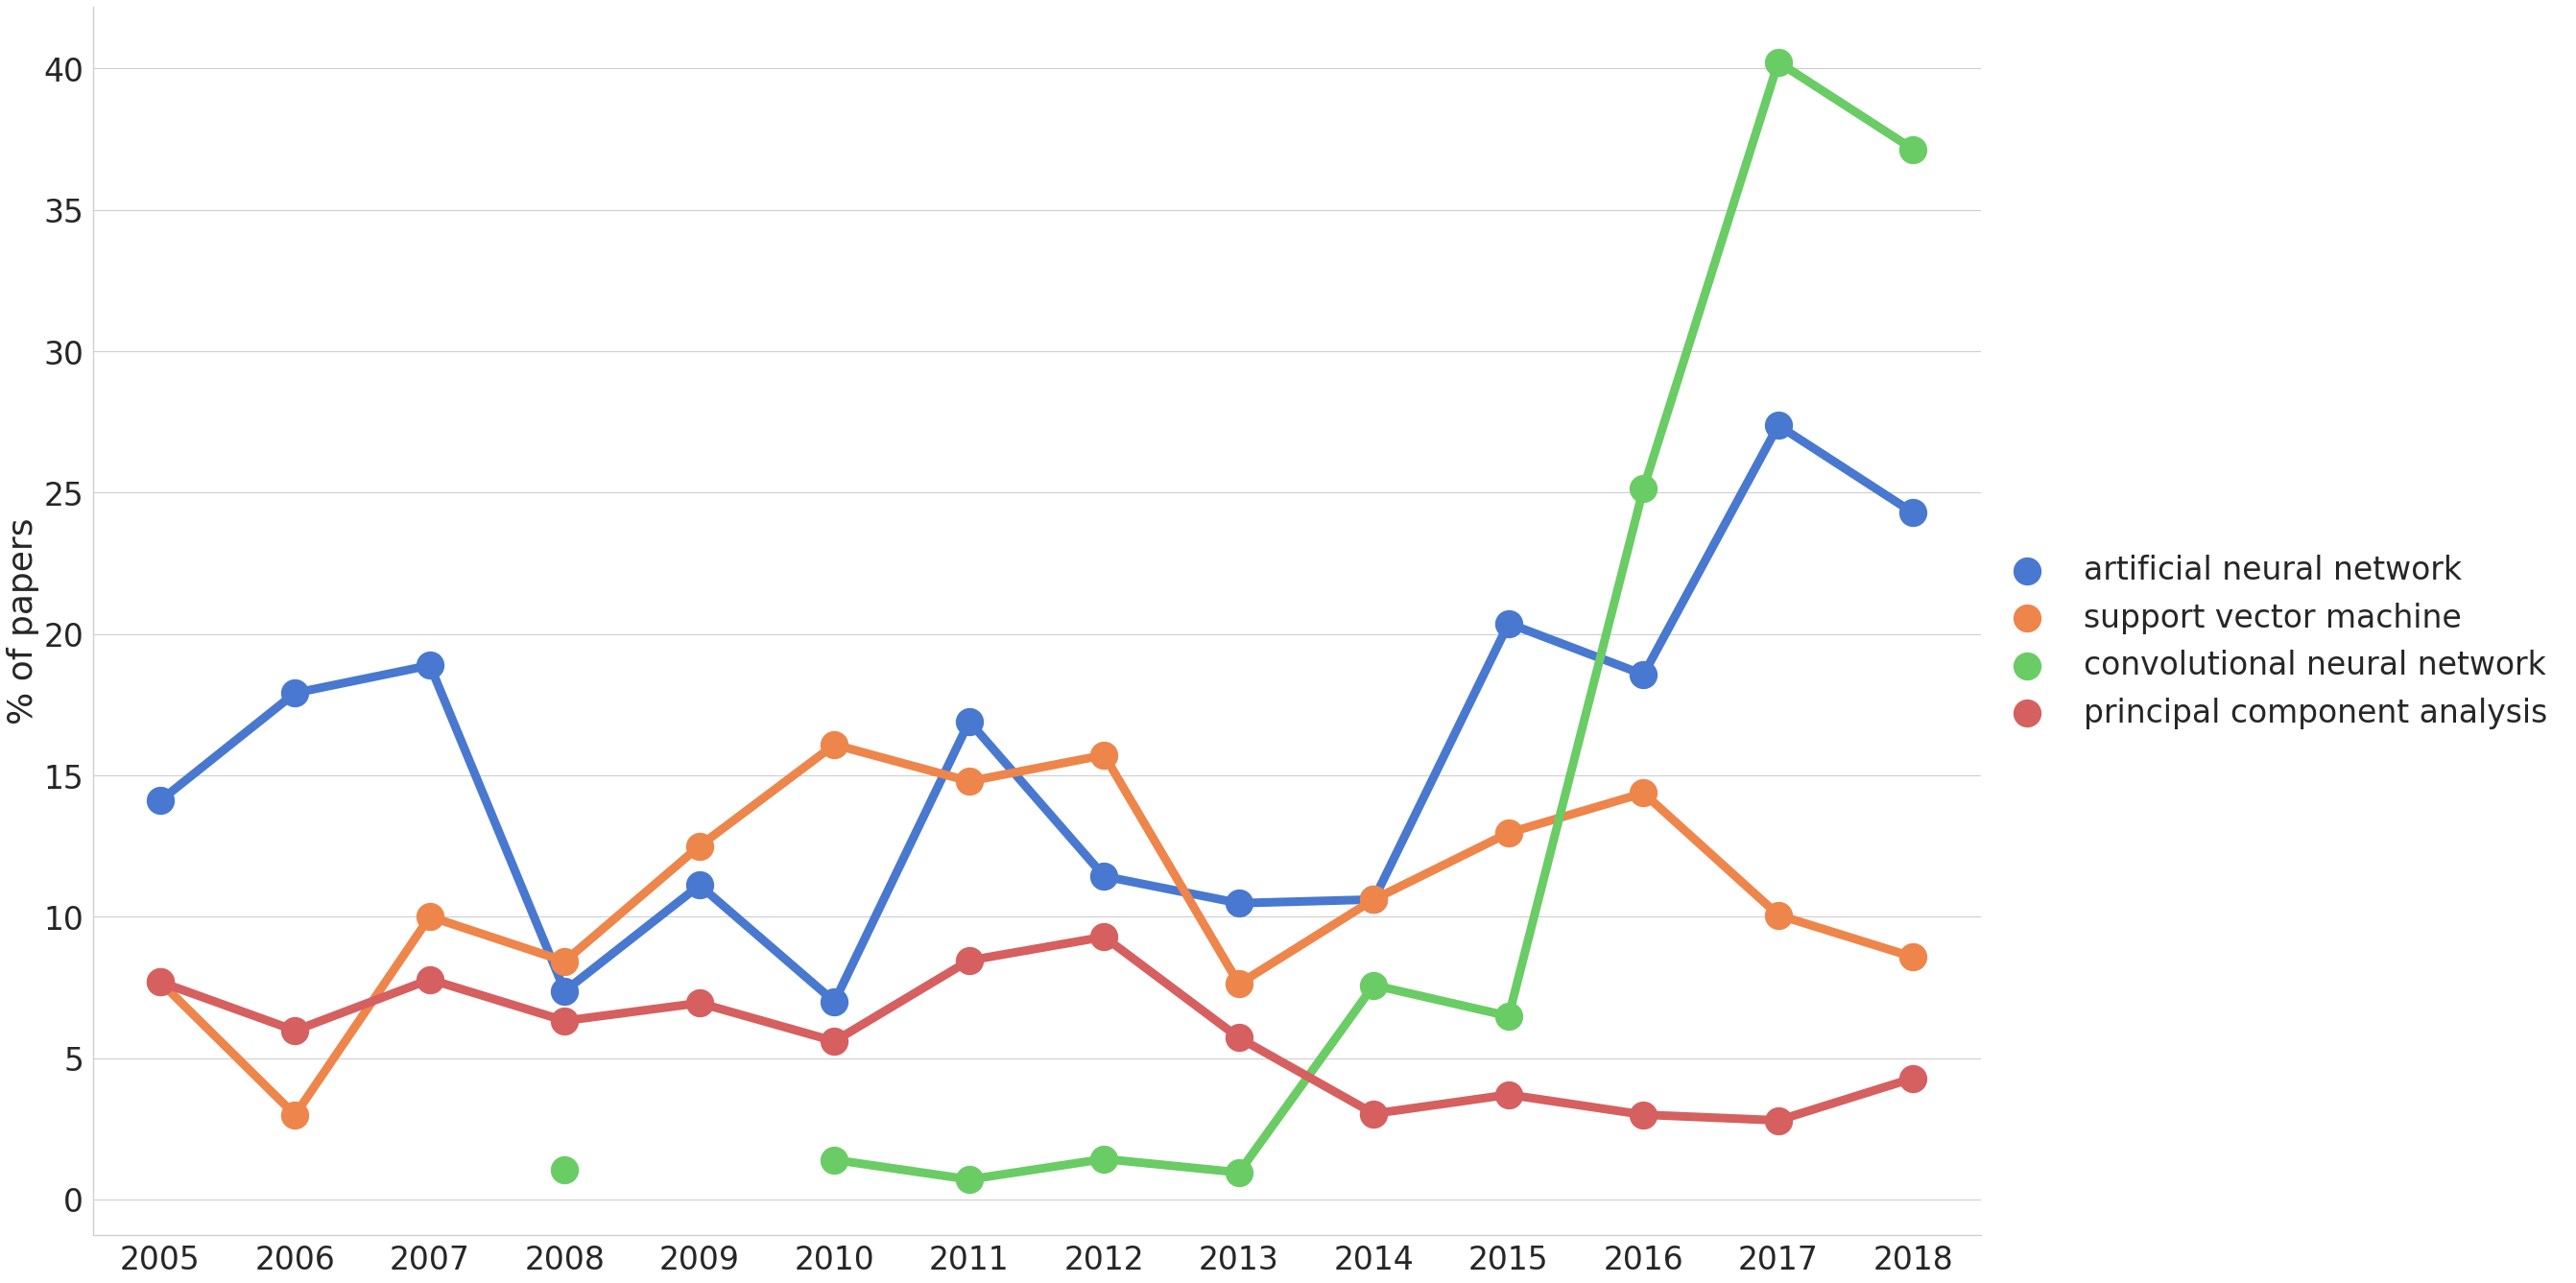

In [76]:
data = data.sort_values('method')
sns.set(style="whitegrid", font_scale=3, rc={"lines.linewidth": 5})
g = sns.catplot(x="published_year", y="count_rel", hue="method", data=data,
                kind="point", height=20, aspect=1.5, palette=sns.color_palette("muted"), hue_order=entities)
g.set_axis_labels("", "% of papers")
g._legend.set_title("")

In [87]:
data = data.sort_values(['method', 'published_year'])[['method', 'published_year', 'count_rel']]

data.to_csv('computer_vision.csv')